### 第一版本（不用了）

In [2]:
# import os
# import numpy as np
# import pandas as pd
# import plotly.graph_objects as go

# from sklearn.metrics import (
#     confusion_matrix,
#     roc_auc_score,
#     average_precision_score,
#     f1_score,
#     matthews_corrcoef
# )

# # ======================================================
# # Config
# # ======================================================
# PRED_PATH = "sample_level_predictions/all_models_sample_predictions.csv"
# OUTDIR = "stepwise_outputs"
# os.makedirs(OUTDIR, exist_ok=True)
# os.makedirs(f"{OUTDIR}/plots", exist_ok=True)
# os.makedirs(f"{OUTDIR}/tables", exist_ok=True)

# # model tags (必须与你 inference 一致)
# TAG_M1 = "Radiomics_Only"                # Echo-Net
# TAG_M3 = "Radiomics_plus_AllClinical"
# TAG_M4 = "ClinicalA_Only"
# TAG_M5 = "BaseClinical_Only"

# # ======================================================
# # Utils
# # ======================================================
# def safe_div(a, b):
#     return a / (b + 1e-12)

# def binary_metrics(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
#     return {
#         "TP": tp, "TN": tn, "FP": fp, "FN": fn,
#         "Sensitivity": safe_div(tp, tp + fn),
#         "Specificity": safe_div(tn, tn + fp),
#         "PPV": safe_div(tp, tp + fp),
#         "NPV": safe_div(tn, tn + fn),
#         "Accuracy": safe_div(tp + tn, tp + tn + fp + fn),
#         "F1": f1_score(y_true, y_pred) if (tp + fp + fn) > 0 else 0.0,
#         "MCC": matthews_corrcoef(y_true, y_pred) if len(np.unique(y_pred)) > 1 else 0.0
#     }

# def youden_threshold(y, p):
#     best_j, best_t = -1, 0.5
#     for t in np.linspace(0.05, 0.95, 181):
#         yp = (p >= t).astype(int)
#         m = binary_metrics(y, yp)
#         j = m["Sensitivity"] + m["Specificity"] - 1
#         if j > best_j:
#             best_j, best_t = j, t
#     return best_t

# def stepwise_two_stage(y, p1, T_low, T_high, p2, thr2):
#     zone = np.full(len(y), "gray", dtype=object)
#     zone[p1 < T_low] = "low"
#     zone[p1 > T_high] = "high"

#     y_pred = np.zeros(len(y), dtype=int)
#     y_pred[zone == "high"] = 1
#     gray = zone == "gray"
#     y_pred[gray] = (p2[gray] >= thr2).astype(int)

#     return zone, y_pred

# # ======================================================
# # Sankey
# # ======================================================
# def sankey_flows(y, zone, ypred):
#     flows = []

#     def add(s, t, m):
#         n = int(m.sum())
#         if n > 0:
#             flows.append((s, t, n))

#     m = zone == "low"
#     add("Rule-out", "TN", m & (y == 0))
#     add("Rule-out", "FN", m & (y == 1))

#     m = zone == "gray"
#     add("Grey", "TN", m & (y == 0) & (ypred == 0))
#     add("Grey", "FN", m & (y == 1) & (ypred == 0))
#     add("Grey", "FP", m & (y == 0) & (ypred == 1))
#     add("Grey", "TP", m & (y == 1) & (ypred == 1))

#     m = zone == "high"
#     add("Rule-in", "FP", m & (y == 0))
#     add("Rule-in", "TP", m & (y == 1))

#     return flows

# def plot_sankey(flows, title, out_html):
#     nodes = ["Rule-out", "Grey", "Rule-in", "TN", "FN", "FP", "TP"]
#     colors = {
#         "Rule-out": "#9ecae1", "Grey": "#fdd0a2", "Rule-in": "#fdae6b",
#         "TN": "#6baed6", "FN": "#2171b5",
#         "FP": "#fc9272", "TP": "#de2d26"
#     }
#     idx = {n: i for i, n in enumerate(nodes)}

#     s, t, v, c = [], [], [], []
#     for a, b, n in flows:
#         s.append(idx[a])
#         t.append(idx[b])
#         v.append(n)
#         c.append(colors[b])

#     fig = go.Figure(go.Sankey(
#         node=dict(label=nodes, color=[colors[n] for n in nodes]),
#         link=dict(source=s, target=t, value=v, color=c)
#     ))
#     fig.update_layout(title_text=title)
#     fig.write_html(out_html)

# # ======================================================
# # Main
# # ======================================================
# def main():
#     df = pd.read_csv(PRED_PATH)

#     wide = df.pivot_table(
#         index=["Split", "PatientID"],
#         columns="Model",
#         values=["TrueLabel", "PredProb"],
#         aggfunc="first"
#     ).reset_index()

#     wide.columns = [f"{a}_{b}" if b else a for a, b in wide.columns]

#     wide = wide.rename(columns={
#         f"PredProb_{TAG_M1}": "p_M1",
#         f"PredProb_{TAG_M3}": "p_M3",
#         f"PredProb_{TAG_M4}": "p_M4",
#         f"PredProb_{TAG_M5}": "p_M5",
#         f"TrueLabel_{TAG_M1}": "y"
#     })

#     val = wide[wide["Split"] == "Val"]
#     thr_M1 = youden_threshold(val["y"], val["p_M1"])

#     # 简化：示例阈值（真实使用请换成你前面算的 A/B）
#     T_LOW_M4, T_HIGH_M4 = 0.35, 0.75
#     T_LOW_M5, T_HIGH_M5 = 0.30, 0.70

#     rows = []

#     for cohort in ["Test", "External"]:
#         d = wide[wide["Split"] == cohort]
#         y = d["y"].values

#         # stepwise1
#         z1, yp1 = stepwise_two_stage(
#             y, d["p_M4"].values, T_LOW_M4, T_HIGH_M4,
#             d["p_M1"].values, thr_M1
#         )
#         m1 = binary_metrics(y, yp1)
#         auc1 = roc_auc_score(y, d["p_M4"])
#         rows.append({"Cohort": cohort, "Strategy": "Stepwise1", **m1, "AUROC": auc1})

#         flows = sankey_flows(y, z1, yp1)
#         plot_sankey(
#             flows,
#             f"Stepwise1 flow ({cohort})",
#             f"{OUTDIR}/plots/sankey_stepwise1_{cohort}.html"
#         )

#         # stepwise2
#         z2, yp2 = stepwise_two_stage(
#             y, d["p_M5"].values, T_LOW_M5, T_HIGH_M5,
#             d["p_M1"].values, thr_M1
#         )
#         m2 = binary_metrics(y, yp2)
#         auc2 = roc_auc_score(y, d["p_M5"])
#         rows.append({"Cohort": cohort, "Strategy": "Stepwise2", **m2, "AUROC": auc2})

#         flows = sankey_flows(y, z2, yp2)
#         plot_sankey(
#             flows,
#             f"Stepwise2 flow ({cohort})",
#             f"{OUTDIR}/plots/sankey_stepwise2_{cohort}.html"
#         )

#     table2 = pd.DataFrame(rows)
#     table2.to_csv(f"{OUTDIR}/tables/Table2_diagnostic_performance.csv", index=False)

#     print("✔ Stepwise full pipeline finished.")

# if __name__ == "__main__":
#     main()


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# -----------------------------
# Config: mapping your model tags
# -----------------------------
TAG_M1 = "Radiomics_Only"              # Echo-Net
TAG_M3 = "Radiomics_plus_AllClinical"  # Echo-Net + A + 6-7
TAG_M4 = "ClinicalA_Only"              # A parameter
TAG_M5 = "BaseClinical_Only"           # 6-7 clinical

OUTDIR = "stepwise_outputs"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(f"{OUTDIR}/candidate_tables", exist_ok=True)
os.makedirs(f"{OUTDIR}/summary_tables", exist_ok=True)
os.makedirs(f"{OUTDIR}/plots", exist_ok=True)


# -----------------------------
# Utilities
# -----------------------------
def safe_div(a, b):
    return a / (b + 1e-12)

def find_best_threshold_youden(y_true, y_prob):
    best_thr, best_j = 0.5, -1e9
    for thr in np.linspace(0.05, 0.95, 181):
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        sens = safe_div(tp, tp + fn)
        spec = safe_div(tn, tn + fp)
        j = sens + spec - 1
        if j > best_j:
            best_j, best_thr = j, thr
    return float(best_thr)

def compute_basic_metrics_binary(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sens = safe_div(tp, tp + fn)
    spec = safe_div(tn, tn + fp)
    ppv  = safe_div(tp, tp + fp)
    npv  = safe_div(tn, tn + fn)
    acc  = safe_div(tp + tn, tp + tn + fp + fn)
    return dict(TP=tp, TN=tn, FP=fp, FN=fn,
                Sensitivity=sens, Specificity=spec, PPV=ppv, NPV=npv, Accuracy=acc)

def build_candidate_tables(y, p, cuts):
    """
    Return:
      low_table: for p < cut  (low-risk), includes NPV_low
      high_table: for p > cut (high-risk), includes PPV_high and Spec (global, pred=1 if p>cut else 0)
    """
    rows_low, rows_high = [], []
    N = len(y)

    for cut in cuts:
        # low-risk subset
        low_mask = p < cut
        n_low = int(low_mask.sum())
        if n_low > 0:
            y_low = y[low_mask]
            n_pos_low = int((y_low == 1).sum())
            n_neg_low = n_low - n_pos_low
            npv_low = safe_div(n_neg_low, n_low)
        else:
            n_pos_low = 0
            n_neg_low = 0
            npv_low = np.nan

        rows_low.append({
            "low_cut": cut,
            "n_low": n_low,
            "low_ratio": safe_div(n_low, N),
            "n_pos_low": n_pos_low,
            "pos_ratio_low": safe_div(n_pos_low, n_low) if n_low > 0 else np.nan,
            "NPV_low": npv_low
        })

        # high-risk subset
        high_mask = p > cut
        n_high = int(high_mask.sum())
        if n_high > 0:
            y_high = y[high_mask]
            n_pos_high = int((y_high == 1).sum())
            n_neg_high = n_high - n_pos_high
            ppv_high = safe_div(n_pos_high, n_high)
        else:
            n_pos_high = 0
            n_neg_high = 0
            ppv_high = np.nan

        # global specificity if we say pred=1 when p>cut else 0
        y_pred_global = (p > cut).astype(int)
        m = compute_basic_metrics_binary(y, y_pred_global)

        rows_high.append({
            "high_cut": cut,
            "n_high": n_high,
            "high_ratio": safe_div(n_high, N),
            "n_pos_high": n_pos_high,
            "pos_ratio_high": safe_div(n_pos_high, n_high) if n_high > 0 else np.nan,
            "PPV_high": ppv_high,
            "Specificity_global": m["Specificity"],
            "Sensitivity_global": m["Sensitivity"],
        })

    return pd.DataFrame(rows_low), pd.DataFrame(rows_high)

def select_thresholds_scheme(low_table, high_table, scheme="A"):
    """
    scheme A:
      T_low: max low_cut s.t. NPV_low>=0.97 and low_ratio>=0.30
      T_high: min high_cut s.t. PPV_high>=0.80 and Spec>=0.85
    scheme B:
      T_low: max low_cut s.t. NPV_low>=0.95 and low_ratio>=0.30
      T_high: min high_cut s.t. PPV_high>=0.70 and Spec>=0.85
    """
    if scheme == "A":
        npv_thr, low_ratio_thr = 0.97, 0.30
        ppv_thr, spec_thr = 0.80, 0.85
    else:
        npv_thr, low_ratio_thr = 0.95, 0.30
        ppv_thr, spec_thr = 0.70, 0.85

    low_ok = low_table[(low_table["NPV_low"] >= npv_thr) & (low_table["low_ratio"] >= low_ratio_thr)]
    T_low = float(low_ok["low_cut"].max()) if len(low_ok) else np.nan

    high_ok = high_table[(high_table["PPV_high"] >= ppv_thr) & (high_table["Specificity_global"] >= spec_thr)]
    T_high = float(high_ok["high_cut"].min()) if len(high_ok) else np.nan

    return T_low, T_high

def plot_curves(val_df, model_tag, cuts, T_low_A, T_high_A, T_low_B, T_high_B, out_png):
    """
    Plot NPV_low, PPV_high, Sens_global, Spec_global vs cut on validation set.
    """
    y = val_df["TrueLabel"].values.astype(int)
    p = val_df[model_tag].values.astype(float)

    low_table, high_table = build_candidate_tables(y, p, cuts)

    # merge by cut to a single dataframe
    curve = pd.DataFrame({"cut": cuts})
    curve["NPV_low"] = low_table["NPV_low"].values
    curve["PPV_high"] = high_table["PPV_high"].values
    curve["Sensitivity"] = high_table["Sensitivity_global"].values
    curve["Specificity"] = high_table["Specificity_global"].values

    plt.figure()
    plt.plot(curve["cut"], curve["NPV_low"], label="NPV (low zone)")
    plt.plot(curve["cut"], curve["PPV_high"], label="PPV (high zone)")
    plt.plot(curve["cut"], curve["Sensitivity"], label="Sensitivity (global @ pred=p>cut)")
    plt.plot(curve["cut"], curve["Specificity"], label="Specificity (global @ pred=p>cut)")

    # mark thresholds
    for x, txt in [(T_low_A, "T_low(A)"), (T_high_A, "T_high(A)"),
                   (T_low_B, "T_low(B)"), (T_high_B, "T_high(B)")]:
        if np.isfinite(x):
            plt.axvline(x=x, linestyle="--")
            plt.text(x, 0.02, txt, rotation=90, va="bottom")

    plt.xlabel("cut")
    plt.ylabel("value")
    plt.title(f"Validation curves - {model_tag}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

def assign_zone(p, T_low, T_high):
    """
    return zone: 'low','gray','high'
    """
    z = np.full(len(p), "gray", dtype=object)
    z[p < T_low] = "low"
    z[p > T_high] = "high"
    return z

def zone_stats(y, zone):
    """
    returns dict with counts/ratios/pos counts/pos ratios and low NPV / high PPV
    """
    N = len(y)
    out = {}
    for name in ["low", "gray", "high"]:
        m = (zone == name)
        n = int(m.sum())
        n_pos = int((y[m] == 1).sum()) if n > 0 else 0
        out[f"n_{name}"] = n
        out[f"ratio_{name}"] = safe_div(n, N)
        out[f"n_pos_{name}"] = n_pos
        out[f"pos_ratio_{name}"] = safe_div(n_pos, n) if n > 0 else np.nan

    # low NPV, high PPV
    n_low = out["n_low"]
    if n_low > 0:
        n_neg_low = n_low - out["n_pos_low"]
        out["NPV_low"] = safe_div(n_neg_low, n_low)
    else:
        out["NPV_low"] = np.nan

    n_high = out["n_high"]
    if n_high > 0:
        out["PPV_high"] = safe_div(out["n_pos_high"], n_high)
    else:
        out["PPV_high"] = np.nan

    return out

def overall_metrics_with_gray(y, zone, mode="rule_out"):
    """
    For single-step (still has gray), provide two conventional ways:
      rule_out: gray treated as positive (gray+high = positive, low = negative)
      rule_in:  high positive, low+gray negative
    """
    if mode == "rule_out":
        y_pred = np.isin(zone, ["gray", "high"]).astype(int)
    else:
        y_pred = (zone == "high").astype(int)
    return compute_basic_metrics_binary(y, y_pred)

def stepwise_two_stage(y, p_stage1, T_low, T_high, p_stage2, thr_stage2):
    """
    stage1: three-zone by (T_low, T_high)
    stage2: ONLY for gray, binary by thr_stage2
    final: binary prediction for all
      low -> 0
      high -> 1
      gray -> (p_stage2>=thr_stage2)
    return zone_stage1, y_pred_final, extra: gray_count, stage2_perf_on_gray
    """
    zone1 = assign_zone(p_stage1, T_low, T_high)

    y_pred = np.zeros(len(y), dtype=int)
    y_pred[zone1 == "high"] = 1

    gray_idx = (zone1 == "gray")
    if gray_idx.any():
        y_pred[gray_idx] = (p_stage2[gray_idx] >= thr_stage2).astype(int)

    # stage2 performance only on gray
    stage2_metrics = None
    if gray_idx.sum() > 0:
        stage2_metrics = compute_basic_metrics_binary(y[gray_idx], (p_stage2[gray_idx] >= thr_stage2).astype(int))

    return zone1, y_pred, stage2_metrics


# -----------------------------
# Main
# -----------------------------
def main():
    pred_path = "sample_level_predictions/all_models_sample_predictions.csv"
    df = pd.read_csv(pred_path)

    # Pivot to wide: one row per (Split, PatientID)
    wide = df.pivot_table(
        index=["Split", "PatientID"],
        columns="Model",
        values=["TrueLabel", "PredProb"],
        aggfunc="first"
    ).reset_index()

    # flatten columns
    wide.columns = [
        f"{a}_{b}" if b else a
        for (a, b) in wide.columns.to_flat_index()
    ]

    # keep one TrueLabel (all models same)
    # choose TrueLabel from TAG_M1
    wide = wide.rename(columns={f"PredProb_{TAG_M1}": TAG_M1,
                                f"PredProb_{TAG_M3}": TAG_M3,
                                f"PredProb_{TAG_M4}": TAG_M4,
                                f"PredProb_{TAG_M5}": TAG_M5,
                                f"TrueLabel_{TAG_M1}": "TrueLabel"})
    need_cols = ["Split", "PatientID", "TrueLabel", TAG_M1, TAG_M3, TAG_M4, TAG_M5]
    wide = wide[need_cols].dropna()

    # validation set
    val = wide[wide["Split"] == "Val"].copy()
    yv = val["TrueLabel"].values.astype(int)

    # 1) choose M1 single threshold (for step2 in stepwise1/2)
    thr_m1 = find_best_threshold_youden(yv, val[TAG_M1].values.astype(float))

    # 2) gray thresholds for models needed (M4, M5, M1, M3)
    cuts = np.linspace(0.05, 0.95, 181)

    selected_rows = []
    for model_tag in [TAG_M4, TAG_M5, TAG_M1, TAG_M3]:
        p = val[model_tag].values.astype(float)
        low_table, high_table = build_candidate_tables(yv, p, cuts)

        low_table.to_csv(f"{OUTDIR}/candidate_tables/{model_tag}_low_candidates.csv", index=False)
        high_table.to_csv(f"{OUTDIR}/candidate_tables/{model_tag}_high_candidates.csv", index=False)

        T_low_A, T_high_A = select_thresholds_scheme(low_table, high_table, scheme="A")
        T_low_B, T_high_B = select_thresholds_scheme(low_table, high_table, scheme="B")

        selected_rows.append({
            "Model": model_tag,
            "T_low_A": T_low_A, "T_high_A": T_high_A,
            "T_low_B": T_low_B, "T_high_B": T_high_B,
            "thr_youden_for_binary": thr_m1 if model_tag == TAG_M1 else np.nan
        })

        plot_curves(
            val, model_tag, cuts,
            T_low_A, T_high_A, T_low_B, T_high_B,
            out_png=f"{OUTDIR}/plots/val_curves_{model_tag}.png"
        )

    thr_df = pd.DataFrame(selected_rows)
    thr_df.to_csv(f"{OUTDIR}/thresholds_selected.csv", index=False)

    # helper to fetch thresholds
    def get_T(model_tag, scheme):
        row = thr_df[thr_df["Model"] == model_tag].iloc[0]
        return (row[f"T_low_{scheme}"], row[f"T_high_{scheme}"])

    # Evaluate strategies on Test & External for scheme A and B
    cohorts = ["Test", "External"]
    schemes = ["A", "B"]

    zone_records = []
    overall_records = []
    stage2_records = []

    for cohort in cohorts:
        d = wide[wide["Split"] == cohort].copy()
        y = d["TrueLabel"].values.astype(int)

        for scheme in schemes:
            # thresholds
            T4_low, T4_high = get_T(TAG_M4, scheme)
            T5_low, T5_high = get_T(TAG_M5, scheme)
            T1_low, T1_high = get_T(TAG_M1, scheme)
            T3_low, T3_high = get_T(TAG_M3, scheme)

            p1 = d[TAG_M1].values.astype(float)
            p3 = d[TAG_M3].values.astype(float)
            p4 = d[TAG_M4].values.astype(float)
            p5 = d[TAG_M5].values.astype(float)

            # ----------------
            # Stepwise 1: M4 -> (gray to M1 by single thr_m1)
            # ----------------
            zone1_s1, ypred_s1, s1_stage2 = stepwise_two_stage(y, p4, T4_low, T4_high, p1, thr_m1)
            m_s1 = compute_basic_metrics_binary(y, ypred_s1)
            zs_s1 = zone_stats(y, zone1_s1)

            zone_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise1 (M4->M1)",
                **zs_s1
            })
            overall_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise1 (M4->M1)",
                **m_s1,
                "Gray_zone_ratio_after_all": 0.0  # stage2 makes it binary
            })
            if s1_stage2 is not None:
                stage2_records.append({
                    "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise1 stage2 on gray (M1)",
                    "n_gray": int((zone1_s1 == "gray").sum()),
                    **s1_stage2
                })

            # ----------------
            # Stepwise 2: M5 -> (gray to M1)
            # ----------------
            zone1_s2, ypred_s2, s2_stage2 = stepwise_two_stage(y, p5, T5_low, T5_high, p1, thr_m1)
            m_s2 = compute_basic_metrics_binary(y, ypred_s2)
            zs_s2 = zone_stats(y, zone1_s2)

            zone_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise2 (M5->M1)",
                **zs_s2
            })
            overall_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise2 (M5->M1)",
                **m_s2,
                "Gray_zone_ratio_after_all": 0.0
            })
            if s2_stage2 is not None:
                stage2_records.append({
                    "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise2 stage2 on gray (M1)",
                    "n_gray": int((zone1_s2 == "gray").sum()),
                    **s2_stage2
                })

            # ----------------
            # Stepwise 3: M1 only, gray zone exists -> rule_out & rule_in metrics
            # ----------------
            zone_s3 = assign_zone(p1, T1_low, T1_high)
            zs_s3 = zone_stats(y, zone_s3)
            m_s3_out = overall_metrics_with_gray(y, zone_s3, mode="rule_out")
            m_s3_in  = overall_metrics_with_gray(y, zone_s3, mode="rule_in")

            zone_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise3 (M1 only)",
                **zs_s3
            })
            overall_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise3 (M1 only) [rule-out]",
                **m_s3_out,
                "Gray_zone_ratio_after_all": float((zone_s3 == "gray").mean())
            })
            overall_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise3 (M1 only) [rule-in]",
                **m_s3_in,
                "Gray_zone_ratio_after_all": float((zone_s3 == "gray").mean())
            })

            # ----------------
            # Stepwise 4: M3 only
            # ----------------
            zone_s4 = assign_zone(p3, T3_low, T3_high)
            zs_s4 = zone_stats(y, zone_s4)
            m_s4_out = overall_metrics_with_gray(y, zone_s4, mode="rule_out")
            m_s4_in  = overall_metrics_with_gray(y, zone_s4, mode="rule_in")

            zone_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise4 (M3 only)",
                **zs_s4
            })
            overall_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise4 (M3 only) [rule-out]",
                **m_s4_out,
                "Gray_zone_ratio_after_all": float((zone_s4 == "gray").mean())
            })
            overall_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise4 (M3 only) [rule-in]",
                **m_s4_in,
                "Gray_zone_ratio_after_all": float((zone_s4 == "gray").mean())
            })

    zone_df = pd.DataFrame(zone_records)
    overall_df = pd.DataFrame(overall_records)
    stage2_df = pd.DataFrame(stage2_records) if len(stage2_records) else pd.DataFrame()

    zone_df.to_csv(f"{OUTDIR}/summary_tables/stepwise_zone_stats.csv", index=False)
    overall_df.to_csv(f"{OUTDIR}/summary_tables/stepwise_overall_metrics.csv", index=False)
    if len(stage2_df):
        stage2_df.to_csv(f"{OUTDIR}/summary_tables/stepwise_stage2_gray_metrics.csv", index=False)

    # -----------------------------
    # Plots: comparisons
    # -----------------------------
    # 1) stage2 comparison: stepwise1 gray->M1 vs stepwise2 gray->M1
    if len(stage2_df):
        for cohort in cohorts:
            for scheme in schemes:
                sub = stage2_df[(stage2_df["Cohort"] == cohort) & (stage2_df["Scheme"] == scheme)].copy()
                if len(sub) == 0:
                    continue

                # bar: n_gray
                plt.figure()
                x = np.arange(len(sub))
                plt.bar(x, sub["n_gray"].values)
                plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
                plt.ylabel("n (gray into M1)")
                plt.title(f"Stage2 gray size comparison - {cohort} - scheme {scheme}")
                plt.tight_layout()
                plt.savefig(f"{OUTDIR}/plots/stage2_gray_size_{cohort}_scheme{scheme}.png", dpi=200)
                plt.close()

                # bar: sensitivity/spec on gray
                plt.figure()
                x = np.arange(len(sub))
                plt.bar(x, sub["Sensitivity"].values)
                plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
                plt.ylabel("Sensitivity (on gray only)")
                plt.title(f"Stage2 Sensitivity on gray - {cohort} - scheme {scheme}")
                plt.tight_layout()
                plt.savefig(f"{OUTDIR}/plots/stage2_gray_sens_{cohort}_scheme{scheme}.png", dpi=200)
                plt.close()

    # 2) overall comparison among strategies (focus: Accuracy/Sens/Spec + gray_ratio)
    # pick a compact subset: stepwise1, stepwise2, stepwise3 rule-out, stepwise4 rule-out
    pick = overall_df[
        overall_df["Strategy"].isin([
            "stepwise1 (M4->M1)",
            "stepwise2 (M5->M1)",
            "stepwise3 (M1 only) [rule-out]",
            "stepwise4 (M3 only) [rule-out]",
        ])
    ].copy()

    for cohort in cohorts:
        for scheme in schemes:
            sub = pick[(pick["Cohort"] == cohort) & (pick["Scheme"] == scheme)].copy()
            if len(sub) == 0:
                continue

            # Accuracy bar
            plt.figure()
            x = np.arange(len(sub))
            plt.bar(x, sub["Accuracy"].values)
            plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
            plt.ylabel("Accuracy")
            plt.title(f"Overall Accuracy comparison - {cohort} - scheme {scheme}")
            plt.tight_layout()
            plt.savefig(f"{OUTDIR}/plots/overall_accuracy_{cohort}_scheme{scheme}.png", dpi=200)
            plt.close()

            # Gray ratio bar
            plt.figure()
            x = np.arange(len(sub))
            plt.bar(x, sub["Gray_zone_ratio_after_all"].values)
            plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
            plt.ylabel("Gray zone ratio (final)")
            plt.title(f"Gray zone ratio comparison - {cohort} - scheme {scheme}")
            plt.tight_layout()
            plt.savefig(f"{OUTDIR}/plots/overall_grayratio_{cohort}_scheme{scheme}.png", dpi=200)
            plt.close()

    print(f"\n✔ Stepwise evaluation done. Outputs in: {OUTDIR}")
    print(f"  - thresholds: {OUTDIR}/thresholds_selected.csv")
    print(f"  - zone stats: {OUTDIR}/summary_tables/stepwise_zone_stats.csv")
    print(f"  - overall metrics: {OUTDIR}/summary_tables/stepwise_overall_metrics.csv")
    if len(stage2_df):
        print(f"  - stage2 on gray: {OUTDIR}/summary_tables/stepwise_stage2_gray_metrics.csv")
    print(f"  - plots: {OUTDIR}/plots/*.png")


# if __name__ == "__main__":
#     main()


In [8]:
pred_path = "sample_level_predictions/all_models_sample_predictions.csv"
df = pd.read_csv(pred_path)
df

,Model,Split,PatientID,TrueLabel,PredProb,PredLabel
0,Radiomics_Only,Train,1,1,0.999716,1
1,Radiomics_Only,Train,2,0,0.000170,0
2,Radiomics_Only,Train,5,1,0.999552,1
3,Radiomics_Only,Train,6,1,0.999799,1
4,Radiomics_Only,Train,7,0,0.000058,0
...,...,...,...,...,...,...
3040,BaseClinical_Only,External,606,0,0.485927,1
3041,BaseClinical_Only,External,607,0,0.559962,1
3042,BaseClinical_Only,External,608,0,0.524689,1
3043,BaseClinical_Only,External,609,1,0.845600,1


In [11]:
wide = df.pivot_table(
    index=["Split", "PatientID"],
    columns="Model",
    values=["TrueLabel", "PredProb"],
    aggfunc="first"
).reset_index()
wide.columns = [
    f"{a}_{b}" if b else a
    for (a, b) in wide.columns.to_flat_index()
]
wide = wide.rename(columns={f"PredProb_{TAG_M1}": TAG_M1,
                            f"PredProb_{TAG_M3}": TAG_M3,
                            f"PredProb_{TAG_M4}": TAG_M4,
                            f"PredProb_{TAG_M5}": TAG_M5,
                            f"TrueLabel_{TAG_M1}": "TrueLabel"})
need_cols = ["Split", "PatientID", "TrueLabel", TAG_M1, TAG_M3, TAG_M4, TAG_M5]
wide = wide[need_cols].dropna()
wide

,Split,PatientID,TrueLabel,Radiomics_Only,Radiomics_plus_AllClinical,ClinicalA_Only,BaseClinical_Only
0,External,510,1,0.998647,1.000000,0.822399,0.504081
1,External,511,0,0.000468,0.000015,0.739762,0.736759
2,External,512,0,0.000265,0.999960,0.677745,0.786919
3,External,513,1,0.999903,0.999999,0.997583,0.997550
4,External,514,0,0.001112,0.000017,0.059517,0.227406
...,...,...,...,...,...,...,...
604,Val,484,1,0.999433,0.999986,0.984089,0.959666
605,Val,486,1,0.999559,0.999999,0.994991,0.627033
606,Val,488,0,0.000161,0.000032,0.172355,0.315049
607,Val,495,1,0.830693,0.999312,0.943162,0.970353


In [12]:
val = wide[wide["Split"] == "Val"].copy()
yv = val["TrueLabel"].values.astype(int)

In [ ]:
thr_m1 = find_best_threshold_youden(yv, val[TAG_M1].values.astype(float))
thr_m1

0.05

In [22]:
# 2) gray thresholds for models needed (M4, M5, M1, M3)
cuts = np.linspace(0, 1, 1000)
cuts

array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407

lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101      9   0.088235          2       0.222222  0.777778
2   0.020202     12   0.117647          2       0.166667  0.833333
3   0.030303     15   0.147059          3       0.200000  0.800000
4   0.040404     19   0.186275          3       0.157895  0.842105
5   0.050505     21   0.205882          4       0.190476  0.809524
..       ...    ...        ...        ...            ...       ...
95  0.959596     91   0.892157         43       0.472527  0.527473
96  0.969697     91   0.892157         43       0.472527  0.527473
97  0.979798     92   0.901961         44       0.478261  0.521739
98  0.989899     95   0.931373         46       0.484211  0.515789
99  1.000000    102   1.000000         51       0.500000  0.500000

[99 rows x 6 columns]
lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101      9   0.088235          2       0.222222  0.777778
2   0.020

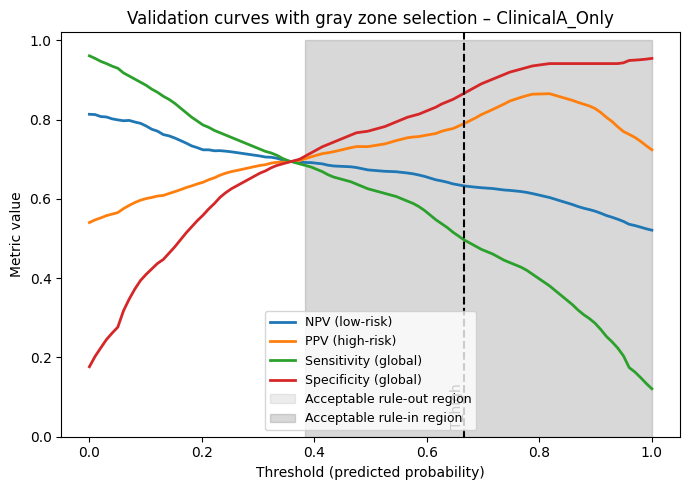

lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101      1   0.009804          1       1.000000  0.000000
2   0.020202      3   0.029412          1       0.333333  0.666667
3   0.030303      4   0.039216          1       0.250000  0.750000
4   0.040404      5   0.049020          1       0.200000  0.800000
5   0.050505      6   0.058824          1       0.166667  0.833333
..       ...    ...        ...        ...            ...       ...
95  0.959596     93   0.911765         43       0.462366  0.537634
96  0.969697     95   0.931373         45       0.473684  0.526316
97  0.979798     96   0.941176         46       0.479167  0.520833
98  0.989899     98   0.960784         48       0.489796  0.510204
99  1.000000    102   1.000000         51       0.500000  0.500000

[99 rows x 6 columns]
lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101      1   0.009804          1       1.000000  0.000000
2   0.020

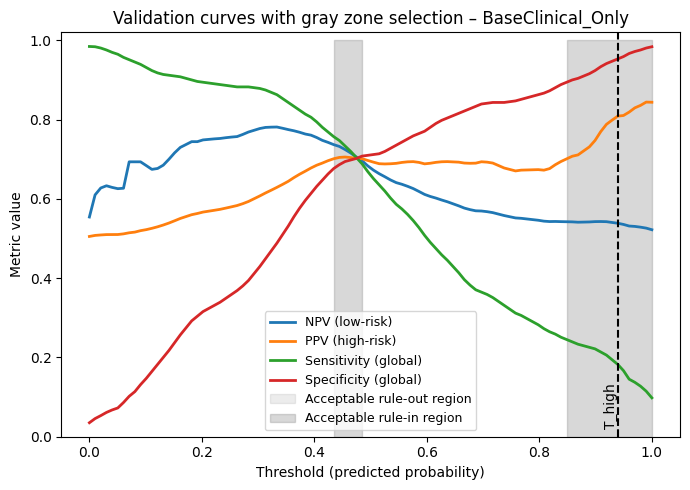

lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101     38   0.372549          7       0.184211  0.815789
2   0.020202     40   0.392157          7       0.175000  0.825000
3   0.030303     40   0.392157          7       0.175000  0.825000
4   0.040404     43   0.421569          8       0.186047  0.813953
5   0.050505     43   0.421569          8       0.186047  0.813953
..       ...    ...        ...        ...            ...       ...
95  0.959596     59   0.578431         18       0.305085  0.694915
96  0.969697     61   0.598039         18       0.295082  0.704918
97  0.979798     62   0.607843         19       0.306452  0.693548
98  0.989899     65   0.637255         20       0.307692  0.692308
99  1.000000    100   0.980392         49       0.490000  0.510000

[99 rows x 6 columns]
lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101     38   0.372549          7       0.184211  0.815789
2   0.020

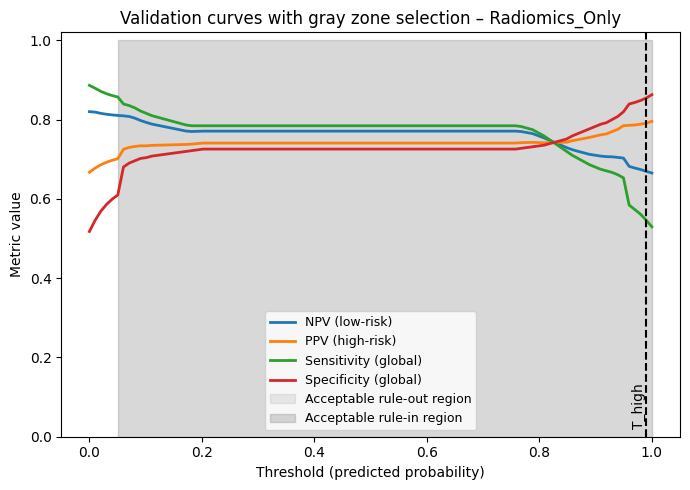

lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101     40   0.392157          9       0.225000  0.775000
2   0.020202     44   0.431373         11       0.250000  0.750000
3   0.030303     44   0.431373         11       0.250000  0.750000
4   0.040404     46   0.450980         12       0.260870  0.739130
5   0.050505     46   0.450980         12       0.260870  0.739130
..       ...    ...        ...        ...            ...       ...
95  0.959596     59   0.578431         18       0.305085  0.694915
96  0.969697     59   0.578431         18       0.305085  0.694915
97  0.979798     61   0.598039         18       0.295082  0.704918
98  0.989899     64   0.627451         20       0.312500  0.687500
99  1.000000    101   0.990196         50       0.495050  0.504950

[99 rows x 6 columns]
lowTable: 99 0      low_cut  n_low  low_ratio  n_pos_low  pos_ratio_low   NPV_low
1   0.010101     40   0.392157          9       0.225000  0.775000
2   0.020

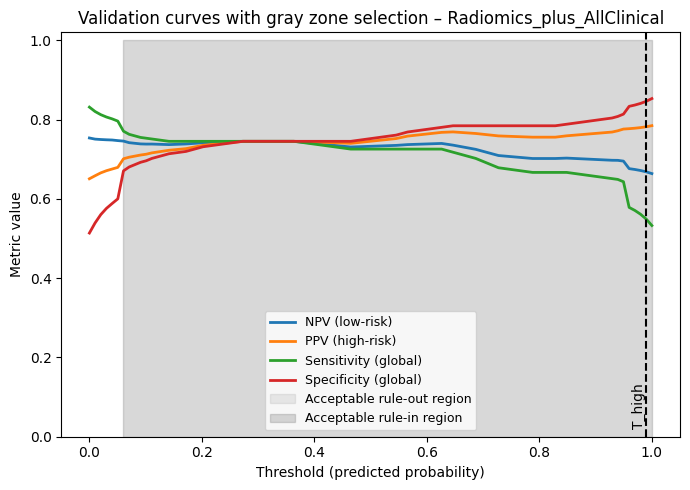

In [56]:
def plot_curves_smooth_with_gray(
    val_df,
    model_tag,
    cuts,
    T_low,
    T_high,
    out_png,
    smooth_window=15,
    # clinical requirements (you can adjust)
    npv_thr=0.7,
    sens_thr=0.7,
    ppv_thr=0.70,
    spec_thr=0.75,
):
    """
    Paper-ready plot:
    - Rolling-smoothed curves (no interpolation)
    - Gray shaded acceptable regions
    - Mark selected T_low / T_high
    """

    y = val_df["TrueLabel"].values.astype(int)
    p = val_df[model_tag].values.astype(float)

    low_table, high_table = build_candidate_tables(y, p, cuts)

    curve = pd.DataFrame({
        "cut": cuts,
        "NPV_low": low_table["NPV_low"].values,
        "PPV_high": high_table["PPV_high"].values,
        "Sensitivity": high_table["Sensitivity_global"].values,
        "Specificity": high_table["Specificity_global"].values,
    })

    # ---------- rolling smoothing (variance reduction, not interpolation)
    curve_s = curve.copy()
    for col in ["NPV_low", "PPV_high", "Sensitivity", "Specificity"]:
        curve_s[col] = (
            curve[col]
            .rolling(window=smooth_window, center=True, min_periods=1)
            .mean()
        )

    plt.figure(figsize=(7, 5))

    # ---------- plot smoothed curves
    plt.plot(curve_s["cut"], curve_s["NPV_low"], label="NPV (low-risk)", lw=2)
    plt.plot(curve_s["cut"], curve_s["PPV_high"], label="PPV (high-risk)", lw=2)
    plt.plot(curve_s["cut"], curve_s["Sensitivity"], label="Sensitivity (global)", lw=2)
    plt.plot(curve_s["cut"], curve_s["Specificity"], label="Specificity (global)", lw=2)

    # ---------- gray zone shading (acceptable regions)
    rule_out_ok = (
        (curve_s["NPV_low"] >= npv_thr) 
    )

    rule_in_ok = (
        (curve_s["PPV_high"] >= ppv_thr) 
    )

    plt.fill_between(
        curve_s["cut"], 0, 1,
        where=rule_out_ok,
        color="gray", alpha=0.15,
        label="Acceptable rule-out region"
    )

    plt.fill_between(
        curve_s["cut"], 0, 1,
        where=rule_in_ok,
        color="gray", alpha=0.30,
        label="Acceptable rule-in region"
    )

    # ---------- mark selected thresholds
    if np.isfinite(T_low):
        plt.axvline(T_low, linestyle="--", color="black")
        plt.text(T_low, 0.02, "T_low", rotation=90, va="bottom", ha="right")

    if np.isfinite(T_high):
        plt.axvline(T_high, linestyle="--", color="black")
        plt.text(T_high, 0.02, "T_high", rotation=90, va="bottom", ha="right")

    plt.xlabel("Threshold (predicted probability)")
    plt.ylabel("Metric value")
    plt.ylim(0, 1.02)
    plt.title(f"Validation curves with gray zone selection – {model_tag}")
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()
    plt.close()


def select_thresholds_scheme(low_table, high_table, scheme="A"):
    """
    scheme A:
      T_low: max low_cut s.t. NPV_low>=0.97 and low_ratio>=0.30
      T_high: min high_cut s.t. PPV_high>=0.80 and Spec>=0.85
    scheme B:
      T_low: max low_cut s.t. NPV_low>=0.95 and low_ratio>=0.30
      T_high: min high_cut s.t. PPV_high>=0.70 and Spec>=0.85
    """
    if scheme == "A":
        npv_thr, low_ratio_thr = 0.9, 0.0
        ppv_thr, spec_thr = 0.80, 0.85
    else:
        npv_thr, low_ratio_thr = 0.9, 0.10
        ppv_thr, spec_thr = 0.70, 0.85
    low_table = low_table.dropna(subset=["NPV_low"])
    low_ok = low_table[(low_table["NPV_low"] >= npv_thr) & (low_table["low_ratio"] >= low_ratio_thr)]
    print('lowTable:', len(low_table), len(low_ok), low_table)
    T_low = float(low_ok["low_cut"].max()) if len(low_ok) else np.nan

    high_ok = high_table[(high_table["PPV_high"] >= ppv_thr) & (high_table["Specificity_global"] >= spec_thr)]
    T_high = float(high_ok["high_cut"].min()) if len(high_ok) else np.nan

    return T_low, T_high

def build_candidate_tables(y, p, cuts):
    """
    Return:
      low_table: for p < cut  (low-risk), includes NPV_low
      high_table: for p > cut (high-risk), includes PPV_high and Spec (global, pred=1 if p>cut else 0)
    """
    rows_low, rows_high = [], []
    N = len(y)

    for cut in cuts:
        # low-risk subset
        low_mask = p < cut
        n_low = int(low_mask.sum())
        if n_low > 0:
            y_low = y[low_mask]
            n_pos_low = int((y_low == 1).sum())
            n_neg_low = n_low - n_pos_low
            npv_low = safe_div(n_neg_low, n_low)
        else:
            n_pos_low = 0
            n_neg_low = 0
            npv_low = np.nan

        rows_low.append({
            "low_cut": cut,
            "n_low": n_low,
            "low_ratio": safe_div(n_low, N),
            "n_pos_low": n_pos_low,
            "pos_ratio_low": safe_div(n_pos_low, n_low) if n_low > 0 else np.nan,
            "NPV_low": npv_low
        })

        # high-risk subset
        high_mask = p > cut
        n_high = int(high_mask.sum())
        if n_high > 0:
            y_high = y[high_mask]
            n_pos_high = int((y_high == 1).sum())
            n_neg_high = n_high - n_pos_high
            ppv_high = safe_div(n_pos_high, n_high)
        else:
            n_pos_high = 0
            n_neg_high = 0
            ppv_high = np.nan

        # global specificity if we say pred=1 when p>cut else 0
        y_pred_global = (p > cut).astype(int)
        m = compute_basic_metrics_binary(y, y_pred_global)

        rows_high.append({
            "high_cut": cut,
            "n_high": n_high,
            "high_ratio": safe_div(n_high, N),
            "n_pos_high": n_pos_high,
            "pos_ratio_high": safe_div(n_pos_high, n_high) if n_high > 0 else np.nan,
            "PPV_high": ppv_high,
            "Specificity_global": m["Specificity"],
            "Sensitivity_global": m["Sensitivity"],
        })

    return pd.DataFrame(rows_low), pd.DataFrame(rows_high)


selected_rows = []
CUT_Q = np.linspace(0.0001, 0.9999, 60)

for model_tag in [TAG_M4, TAG_M5, TAG_M1, TAG_M3]:

    p = val[model_tag].values.astype(float)

    # cuts 改成基于该模型的真实分布
    # cuts = np.unique(np.quantile(p, CUT_Q))
    cuts = np.linspace(0, 1, 100)

    # ---------- build candidate tables (不变)
    low_table, high_table = build_candidate_tables(yv, p, cuts)

    low_table.to_csv(
        f"{OUTDIR}/candidate_tables/{model_tag}_low_candidates.csv",
        index=False
    )
    high_table.to_csv(
        f"{OUTDIR}/candidate_tables/{model_tag}_high_candidates.csv",
        index=False
    )

    # ---------- select thresholds (不变)
    T_low_A, T_high_A = select_thresholds_scheme(
        low_table, high_table, scheme="A"
    )
    T_low_B, T_high_B = select_thresholds_scheme(
        low_table, high_table, scheme="B"
    )
    print(T_low_A, T_high_A, T_low_B, T_high_B)
    selected_rows.append({
        "Model": model_tag,
        "T_low_A": T_low_A,
        "T_high_A": T_high_A,
        "T_low_B": T_low_B,
        "T_high_B": T_high_B,
        "thr_youden_for_binary": thr_m1 if model_tag == TAG_M1 else np.nan
    })

    # ---------- ✅ NEW: paper-ready plot (scheme A 为主)
    plot_curves_smooth_with_gray(
        val_df=val,
        model_tag=model_tag,
        cuts=cuts,
        T_low=T_low_A,
        T_high=T_high_A,
        out_png=f"{OUTDIR}/plots/val_curves_{model_tag}.png",
        smooth_window=10,        # 推荐 10–20
        npv_thr=0.9,
        sens_thr=0.9,
        ppv_thr=0.7,
        spec_thr=0.75,
    )
    

In [49]:
low_table

,low_cut,n_low,low_ratio,n_pos_low,pos_ratio_low,NPV_low
0,0.000000,0,0.000000,0,NaN,NaN
1,0.010101,40,0.392157,9,0.225000,0.775000
2,0.020202,44,0.431373,11,0.250000,0.750000
3,0.030303,44,0.431373,11,0.250000,0.750000
4,0.040404,46,0.450980,12,0.260870,0.739130
...,...,...,...,...,...,...
95,0.959596,59,0.578431,18,0.305085,0.694915
96,0.969697,59,0.578431,18,0.305085,0.694915
97,0.979798,61,0.598039,18,0.295082,0.704918
98,0.989899,64,0.627451,20,0.312500,0.687500


In [40]:
T_low_A, T_high_A = select_thresholds_scheme(
        low_table, high_table, scheme="A"
    )
T_low_B, T_high_B = select_thresholds_scheme(
low_table, high_table, scheme="B"
)
T_low_A, T_high_A, T_low_B, T_high_B

(nan, 0.98989898989899, nan, 0.98989898989899)

In [ ]:
# flatten columns
wide.columns = [
    f"{a}_{b}" if b else a
    for (a, b) in wide.columns.to_flat_index()
]

# keep one TrueLabel (all models same)
# choose TrueLabel from TAG_M1
wide = wide.rename(columns={f"PredProb_{TAG_M1}": TAG_M1,
                            f"PredProb_{TAG_M3}": TAG_M3,
                            f"PredProb_{TAG_M4}": TAG_M4,
                            f"PredProb_{TAG_M5}": TAG_M5,
                            f"TrueLabel_{TAG_M1}": "TrueLabel"})
need_cols = ["Split", "PatientID", "TrueLabel", TAG_M1, TAG_M3, TAG_M4, TAG_M5]
wide = wide[need_cols].dropna()

# validation set
val = wide[wide["Split"] == "Val"].copy()
yv = val["TrueLabel"].values.astype(int)

# 1) choose M1 single threshold (for step2 in stepwise1/2)
thr_m1 = find_best_threshold_youden(yv, val[TAG_M1].values.astype(float))

# 2) gray thresholds for models needed (M4, M5, M1, M3)
cuts = np.linspace(0.05, 0.95, 181)

selected_rows = []
for model_tag in [TAG_M4, TAG_M5, TAG_M1, TAG_M3]:
    p = val[model_tag].values.astype(float)
    low_table, high_table = build_candidate_tables(yv, p, cuts)

    low_table.to_csv(f"{OUTDIR}/candidate_tables/{model_tag}_low_candidates.csv", index=False)
    high_table.to_csv(f"{OUTDIR}/candidate_tables/{model_tag}_high_candidates.csv", index=False)

    T_low_A, T_high_A = select_thresholds_scheme(low_table, high_table, scheme="A")
    T_low_B, T_high_B = select_thresholds_scheme(low_table, high_table, scheme="B")

    selected_rows.append({
        "Model": model_tag,
        "T_low_A": T_low_A, "T_high_A": T_high_A,
        "T_low_B": T_low_B, "T_high_B": T_high_B,
        "thr_youden_for_binary": thr_m1 if model_tag == TAG_M1 else np.nan
    })

    plot_curves(
        val, model_tag, cuts,
        T_low_A, T_high_A, T_low_B, T_high_B,
        out_png=f"{OUTDIR}/plots/val_curves_{model_tag}.png"
    )

thr_df = pd.DataFrame(selected_rows)
thr_df.to_csv(f"{OUTDIR}/thresholds_selected.csv", index=False)

# helper to fetch thresholds
def get_T(model_tag, scheme):
    row = thr_df[thr_df["Model"] == model_tag].iloc[0]
    return (row[f"T_low_{scheme}"], row[f"T_high_{scheme}"])

# Evaluate strategies on Test & External for scheme A and B
cohorts = ["Test", "External"]
schemes = ["A", "B"]

zone_records = []
overall_records = []
stage2_records = []

for cohort in cohorts:
    d = wide[wide["Split"] == cohort].copy()
    y = d["TrueLabel"].values.astype(int)

    for scheme in schemes:
        # thresholds
        T4_low, T4_high = get_T(TAG_M4, scheme)
        T5_low, T5_high = get_T(TAG_M5, scheme)
        T1_low, T1_high = get_T(TAG_M1, scheme)
        T3_low, T3_high = get_T(TAG_M3, scheme)

        p1 = d[TAG_M1].values.astype(float)
        p3 = d[TAG_M3].values.astype(float)
        p4 = d[TAG_M4].values.astype(float)
        p5 = d[TAG_M5].values.astype(float)

        # ----------------
        # Stepwise 1: M4 -> (gray to M1 by single thr_m1)
        # ----------------
        zone1_s1, ypred_s1, s1_stage2 = stepwise_two_stage(y, p4, T4_low, T4_high, p1, thr_m1)
        m_s1 = compute_basic_metrics_binary(y, ypred_s1)
        zs_s1 = zone_stats(y, zone1_s1)

        zone_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise1 (M4->M1)",
            **zs_s1
        })
        overall_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise1 (M4->M1)",
            **m_s1,
            "Gray_zone_ratio_after_all": 0.0  # stage2 makes it binary
        })
        if s1_stage2 is not None:
            stage2_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise1 stage2 on gray (M1)",
                "n_gray": int((zone1_s1 == "gray").sum()),
                **s1_stage2
            })

        # ----------------
        # Stepwise 2: M5 -> (gray to M1)
        # ----------------
        zone1_s2, ypred_s2, s2_stage2 = stepwise_two_stage(y, p5, T5_low, T5_high, p1, thr_m1)
        m_s2 = compute_basic_metrics_binary(y, ypred_s2)
        zs_s2 = zone_stats(y, zone1_s2)

        zone_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise2 (M5->M1)",
            **zs_s2
        })
        overall_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise2 (M5->M1)",
            **m_s2,
            "Gray_zone_ratio_after_all": 0.0
        })
        if s2_stage2 is not None:
            stage2_records.append({
                "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise2 stage2 on gray (M1)",
                "n_gray": int((zone1_s2 == "gray").sum()),
                **s2_stage2
            })

        # ----------------
        # Stepwise 3: M1 only, gray zone exists -> rule_out & rule_in metrics
        # ----------------
        zone_s3 = assign_zone(p1, T1_low, T1_high)
        zs_s3 = zone_stats(y, zone_s3)
        m_s3_out = overall_metrics_with_gray(y, zone_s3, mode="rule_out")
        m_s3_in  = overall_metrics_with_gray(y, zone_s3, mode="rule_in")

        zone_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise3 (M1 only)",
            **zs_s3
        })
        overall_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise3 (M1 only) [rule-out]",
            **m_s3_out,
            "Gray_zone_ratio_after_all": float((zone_s3 == "gray").mean())
        })
        overall_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise3 (M1 only) [rule-in]",
            **m_s3_in,
            "Gray_zone_ratio_after_all": float((zone_s3 == "gray").mean())
        })

        # ----------------
        # Stepwise 4: M3 only
        # ----------------
        zone_s4 = assign_zone(p3, T3_low, T3_high)
        zs_s4 = zone_stats(y, zone_s4)
        m_s4_out = overall_metrics_with_gray(y, zone_s4, mode="rule_out")
        m_s4_in  = overall_metrics_with_gray(y, zone_s4, mode="rule_in")

        zone_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise4 (M3 only)",
            **zs_s4
        })
        overall_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise4 (M3 only) [rule-out]",
            **m_s4_out,
            "Gray_zone_ratio_after_all": float((zone_s4 == "gray").mean())
        })
        overall_records.append({
            "Cohort": cohort, "Scheme": scheme, "Strategy": "stepwise4 (M3 only) [rule-in]",
            **m_s4_in,
            "Gray_zone_ratio_after_all": float((zone_s4 == "gray").mean())
        })

zone_df = pd.DataFrame(zone_records)
overall_df = pd.DataFrame(overall_records)
stage2_df = pd.DataFrame(stage2_records) if len(stage2_records) else pd.DataFrame()

zone_df.to_csv(f"{OUTDIR}/summary_tables/stepwise_zone_stats.csv", index=False)
overall_df.to_csv(f"{OUTDIR}/summary_tables/stepwise_overall_metrics.csv", index=False)
if len(stage2_df):
    stage2_df.to_csv(f"{OUTDIR}/summary_tables/stepwise_stage2_gray_metrics.csv", index=False)

# -----------------------------
# Plots: comparisons
# -----------------------------
# 1) stage2 comparison: stepwise1 gray->M1 vs stepwise2 gray->M1
if len(stage2_df):
    for cohort in cohorts:
        for scheme in schemes:
            sub = stage2_df[(stage2_df["Cohort"] == cohort) & (stage2_df["Scheme"] == scheme)].copy()
            if len(sub) == 0:
                continue

            # bar: n_gray
            plt.figure()
            x = np.arange(len(sub))
            plt.bar(x, sub["n_gray"].values)
            plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
            plt.ylabel("n (gray into M1)")
            plt.title(f"Stage2 gray size comparison - {cohort} - scheme {scheme}")
            plt.tight_layout()
            plt.savefig(f"{OUTDIR}/plots/stage2_gray_size_{cohort}_scheme{scheme}.png", dpi=200)
            plt.close()

            # bar: sensitivity/spec on gray
            plt.figure()
            x = np.arange(len(sub))
            plt.bar(x, sub["Sensitivity"].values)
            plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
            plt.ylabel("Sensitivity (on gray only)")
            plt.title(f"Stage2 Sensitivity on gray - {cohort} - scheme {scheme}")
            plt.tight_layout()
            plt.savefig(f"{OUTDIR}/plots/stage2_gray_sens_{cohort}_scheme{scheme}.png", dpi=200)
            plt.close()

# 2) overall comparison among strategies (focus: Accuracy/Sens/Spec + gray_ratio)
# pick a compact subset: stepwise1, stepwise2, stepwise3 rule-out, stepwise4 rule-out
pick = overall_df[
    overall_df["Strategy"].isin([
        "stepwise1 (M4->M1)",
        "stepwise2 (M5->M1)",
        "stepwise3 (M1 only) [rule-out]",
        "stepwise4 (M3 only) [rule-out]",
    ])
].copy()

for cohort in cohorts:
    for scheme in schemes:
        sub = pick[(pick["Cohort"] == cohort) & (pick["Scheme"] == scheme)].copy()
        if len(sub) == 0:
            continue

        # Accuracy bar
        plt.figure()
        x = np.arange(len(sub))
        plt.bar(x, sub["Accuracy"].values)
        plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
        plt.ylabel("Accuracy")
        plt.title(f"Overall Accuracy comparison - {cohort} - scheme {scheme}")
        plt.tight_layout()
        plt.savefig(f"{OUTDIR}/plots/overall_accuracy_{cohort}_scheme{scheme}.png", dpi=200)
        plt.close()

        # Gray ratio bar
        plt.figure()
        x = np.arange(len(sub))
        plt.bar(x, sub["Gray_zone_ratio_after_all"].values)
        plt.xticks(x, sub["Strategy"].values, rotation=30, ha="right")
        plt.ylabel("Gray zone ratio (final)")
        plt.title(f"Gray zone ratio comparison - {cohort} - scheme {scheme}")
        plt.tight_layout()
        plt.savefig(f"{OUTDIR}/plots/overall_grayratio_{cohort}_scheme{scheme}.png", dpi=200)
        plt.close()

print(f"\n✔ Stepwise evaluation done. Outputs in: {OUTDIR}")
print(f"  - thresholds: {OUTDIR}/thresholds_selected.csv")
print(f"  - zone stats: {OUTDIR}/summary_tables/stepwise_zone_stats.csv")
print(f"  - overall metrics: {OUTDIR}/summary_tables/stepwise_overall_metrics.csv")
if len(stage2_df):
    print(f"  - stage2 on gray: {OUTDIR}/summary_tables/stepwise_stage2_gray_metrics.csv")
print(f"  - plots: {OUTDIR}/plots/*.png")

### 第二个版本

In [65]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, f1_score, matthews_corrcoef
)

# =============================
# 0) 你需要根据实际csv改这里
# =============================
PRED_PATH = "sample_level_predictions/all_models_sample_predictions.csv"

# Split 名称：按你真实数据改
SPLIT_VAL = "Val"
SPLIT_INTERNAL_TEST = "Test"          # 你如果叫 InternalTest 就改成 "InternalTest"
SPLIT_PROSPECTIVE_TEST = "External"   # 你如果叫 ProspectiveTest 就改成 "ProspectiveTest"

# 模型 tag：按你真实 Model 字段改（必须和csv里 Model列一致）
TAG_M1 = "Radiomics_Only"                 # M1
TAG_M2 = "Radiomics_plus_A"                    # M2  <-- 你需要填对（示例名）
TAG_M3 = "Radiomics_plus_AllClinical"     # M3
TAG_M4 = "ClinicalA_Only"                 # M4(A参数)
TAG_M5 = "BaseClinical_Only"              # M5

ALL_MODEL_TAGS = [TAG_M1, TAG_M2, TAG_M3, TAG_M4, TAG_M5]

OUTDIR = "stepwise_outputs_v2"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(f"{OUTDIR}/thresholds", exist_ok=True)
os.makedirs(f"{OUTDIR}/tables", exist_ok=True)

# =============================
# 1) 工具函数
# =============================
def safe_div(a, b):
    return a / (b + 1e-12)

def compute_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tp, tn, fp, fn

def compute_metrics_from_pred(y_true, y_pred):
    tp, tn, fp, fn = compute_confusion(y_true, y_pred)
    sens = safe_div(tp, tp + fn)
    spec = safe_div(tn, tn + fp)
    ppv  = safe_div(tp, tp + fp)
    npv  = safe_div(tn, tn + fn)
    acc  = safe_div(tp + tn, tp + tn + fp + fn)
    # 添加AUC、F1、MCC、AUPRC
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)
    

    return {
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "Sensitivity": float(sens),
        "Specificity": float(spec),
        "PPV": float(ppv),
        "NPV": float(npv),
        "Accuracy": float(acc),
        "AUROC": float(auc),
        "F1": float(f1),
        "MCC": float(mcc),
        "AUPRC": float(auprc),
        
    }

def find_best_threshold_youden(y_true, y_prob):
    # 单阈值二分类：Youden J = Sens + Spec - 1
    best_thr, best_j = 0.5, -1e9
    for thr in np.linspace(0.01, 0.99, 199):
        y_pred = (y_prob >= thr).astype(int)
        m = compute_metrics_from_pred(y_true, y_pred)
        j = m["Sensitivity"] + m["Specificity"] - 1
        if j > best_j:
            best_j, best_thr = j, thr
    return float(best_thr)

def stepwise_two_stage_binary(y, p_stage1, thr1, p_stage2, thr2):
    """
    两步筛选（二值阈值，不再用灰区）：
      Step1: pass1 = p1>=thr1  (pass=1 表示进入第二步/转诊到下一步检查)
      Step2: 在 pass1 人群里 pred2 = p2>=thr2
      Final: y_pred_final = pass1 & pred2
    同时输出：Step1全队列指标、Step2子集指标、Final全队列指标，以及进入第二步人数/比例
    """
    N = len(y)
    pass1 = (p_stage1 >= thr1).astype(int)  # 1=进入第二步
    step1_metrics = compute_metrics_from_pred(y, pass1)

    idx = pass1 == 1
    n_stage2 = int(idx.sum())
    stage2_ratio = safe_div(n_stage2, N)

    if n_stage2 > 0:
        pred2 = (p_stage2[idx] >= thr2).astype(int)
        step2_metrics = compute_metrics_from_pred(y[idx], pred2)
    else:
        step2_metrics = {k: np.nan for k in ["TP","TN","FP","FN","Sensitivity","Specificity","PPV","NPV","Accuracy"]}

    y_pred_final = np.zeros(N, dtype=int)
    if n_stage2 > 0:
        y_pred_final[idx] = pred2
    final_metrics = compute_metrics_from_pred(y, y_pred_final)

    return {
        "n_stage2": n_stage2,
        "stage2_ratio": float(stage2_ratio),
        "step1": step1_metrics,
        "step2": step2_metrics,
        "final": final_metrics,
        "y_pred_final": y_pred_final,
        "y_pred_step1": pass1,
    }

def single_model_binary(y, p, thr):
    y_pred = (p >= thr).astype(int)
    return compute_metrics_from_pred(y, y_pred), y_pred

# ---- 配对比较：Referrals avoided + McNemar OR/P ----
def mcnemar_or_p(y_true, pred_a, pred_b):
    """
    以“是否判对”为结局（correct vs incorrect）做配对OR：
      b = A correct, B incorrect
      c = A incorrect, B correct
      OR = b/c
    P值：McNemar exact（binomial on b+c）
    95%CI：log(OR) +/- 1.96*sqrt(1/b + 1/c)
    """
    a_correct = (pred_a == y_true).astype(int)
    b_correct = (pred_b == y_true).astype(int)

    b = int(((a_correct == 1) & (b_correct == 0)).sum())
    c = int(((a_correct == 0) & (b_correct == 1)).sum())

    # OR 与 CI
    if b == 0 or c == 0:
        OR = np.inf if c == 0 and b > 0 else (0.0 if b == 0 and c > 0 else np.nan)
        ci_low, ci_high = np.nan, np.nan
    else:
        OR = b / c
        se = np.sqrt(1/b + 1/c)
        log_or = np.log(OR)
        ci_low = np.exp(log_or - 1.96*se)
        ci_high = np.exp(log_or + 1.96*se)

    # McNemar exact p-value
    # p = 2 * min( BinomCDF(min(b,c); n=b+c, p=0.5), 1-... )
    n = b + c
    if n == 0:
        pval = 1.0
    else:
        # 计算 exact 双侧：2 * sum_{k=0..min(b,c)} C(n,k)/2^n
        from math import comb
        k = min(b, c)
        cdf = sum(comb(n, i) for i in range(0, k+1)) / (2**n)
        pval = min(1.0, 2*cdf)

    return OR, ci_low, ci_high, pval, b, c

def referrals_avoided(pred_a, pred_b):
    """
    Referrals avoided (%)：阳性=转诊
    RA = (pos_rate_B - pos_rate_A) * 100
    解释：A 相对 B 减少了多少转诊
    """
    ra = (pred_b.mean() - pred_a.mean()) * 100.0
    return float(ra)

# =============================
# 2) 读取并整理为 wide 表
# =============================
def load_wide(pred_path):
    df = pd.read_csv(pred_path)

    wide = df.pivot_table(
        index=["Split", "PatientID"],
        columns="Model",
        values=["TrueLabel", "PredProb"],
        aggfunc="first"
    ).reset_index()

    wide.columns = [f"{a}_{b}" if b else a for (a, b) in wide.columns.to_flat_index()]

    # TrueLabel 取任一模型即可（假设一致）
    # 这里用 M1，如果你M1缺失，可以换别的
    wide = wide.rename(columns={
        f"TrueLabel_{TAG_M1}": "TrueLabel",
        f"PredProb_{TAG_M1}": TAG_M1,
        f"PredProb_{TAG_M2}": TAG_M2,
        f"PredProb_{TAG_M3}": TAG_M3,
        f"PredProb_{TAG_M4}": TAG_M4,
        f"PredProb_{TAG_M5}": TAG_M5,
    })

    need = ["Split", "PatientID", "TrueLabel"] + ALL_MODEL_TAGS
    wide = wide[need].dropna()
    wide["TrueLabel"] = wide["TrueLabel"].astype(int)
    return wide

# =============================
# 3) 主流程：阈值(Val) + 各cohort评估
# =============================
def main():
    wide = load_wide(PRED_PATH)

    # ---- 3.1 在验证集上为每个模型选单阈值（Youden）----
    val = wide[wide["Split"] == SPLIT_VAL].copy()
    yv = val["TrueLabel"].values.astype(int)

    thr = {}
    for tag in ALL_MODEL_TAGS:
        thr[tag] = find_best_threshold_youden(yv, val[tag].values.astype(float))

    thr_df = pd.DataFrame([{"Model": k, "Threshold_Youden": v} for k, v in thr.items()])
    thr_df.to_csv(f"{OUTDIR}/thresholds/thresholds_from_val.csv", index=False)

    # ---- 3.2 定义三个多步骤方案（阈值全部来自 Val）----
    # stepwise1: M4 -> M1
    # stepwise2: M5 -> M1
    # stepwise3: M5 -> M2
    strategies = {
        "stepwise1 (M4->M1)": (TAG_M4, TAG_M1),
        "stepwise2 (M5->M1)": (TAG_M5, TAG_M1),
        "stepwise3 (M5->M2)": (TAG_M5, TAG_M2),
    }

    cohorts = {
        "InternalTest": SPLIT_INTERNAL_TEST,
        "ProspectiveTest": SPLIT_PROSPECTIVE_TEST,
    }

    # 输出表：每步指标表（你要的表头类似 stepwise1/2/3）
    step_tables = []   # 表1/2用：逐步
    overall_tables = []  # 整体汇总
    preds_by_cohort = {} # 存每个算法的最终pred用于pairwise比较

    for cohort_name, split_name in cohorts.items():
        d = wide[wide["Split"] == split_name].copy()
        y = d["TrueLabel"].values.astype(int)

        preds_by_cohort[cohort_name] = {}

        # --- 三个多步骤 ---
        for sname, (s1_tag, s2_tag) in strategies.items():
            res = stepwise_two_stage_binary(
                y=y,
                p_stage1=d[s1_tag].values.astype(float),
                thr1=thr[s1_tag],
                p_stage2=d[s2_tag].values.astype(float),
                thr2=thr[s2_tag],
            )

            # Step1记录
            step_tables.append({
                "Cohort": cohort_name,
                "Strategy": sname,
                "Step": "Step1",
                "ModelUsed": s1_tag,
                "Threshold": thr[s1_tag],
                "N_in_step": int(len(y)),
                "N_pass_to_next": res["n_stage2"],
                "Pass_ratio": res["stage2_ratio"],
                **res["step1"]
            })

            # Step2记录（子集）
            step_tables.append({
                "Cohort": cohort_name,
                "Strategy": sname,
                "Step": "Step2",
                "ModelUsed": s2_tag,
                "Threshold": thr[s2_tag],
                "N_in_step": res["n_stage2"],
                "N_pass_to_next": np.nan,
                "Pass_ratio": np.nan,
                **res["step2"]
            })

            # Overall记录（全队列最终）
            overall_tables.append({
                "Cohort": cohort_name,
                "Strategy": sname,
                "Final_referral_rate": float(res["y_pred_final"].mean()),
                "Stage2_entry_ratio": float(res["stage2_ratio"]),
                **res["final"]
            })

            preds_by_cohort[cohort_name][sname] = res["y_pred_final"].copy()

        # --- 单模型 M1~M5 ---
        for tag in ALL_MODEL_TAGS:
            m, pred = single_model_binary(y, d[tag].values.astype(float), thr[tag])
            name = f"single ({tag})"
            overall_tables.append({
                "Cohort": cohort_name,
                "Strategy": name,
                "Final_referral_rate": float(pred.mean()),
                "Stage2_entry_ratio": np.nan,
                **m
            })
            preds_by_cohort[cohort_name][name] = pred.copy()

    step_df = pd.DataFrame(step_tables)
    overall_df = pd.DataFrame(overall_tables)

    step_df.to_csv(f"{OUTDIR}/tables/table_step_metrics_by_cohort.csv", index=False)
    overall_df.to_csv(f"{OUTDIR}/tables/table_overall_metrics_by_cohort.csv", index=False)

    # =============================
    # 4) Pairwise 比较表（你列的那些）
    # =============================
    pairs = [
        ("stepwise1 (M4->M1)", f"single ({TAG_M4})"),     # 步骤1 vs M4
        ("stepwise2 (M5->M1)", f"single ({TAG_M5})"),     # 步骤2 vs M5
        ("stepwise1 (M4->M1)", "stepwise2 (M5->M1)"),     # 步骤1 vs 步骤2
        (f"single ({TAG_M4})", f"single ({TAG_M5})"),     # M4 vs M5
        ("stepwise1 (M4->M1)", f"single ({TAG_M2})"),     # 步骤1 vs M2
        (f"single ({TAG_M2})", f"single ({TAG_M3})"),     # M2 vs M3
        ("stepwise3 (M5->M2)", "stepwise4 (M3 only)"),    # 你写“步骤3(M1) vs 步骤四(M3)”但新方案里步骤3是M5->M2
    ]

    # 上面最后一条：你原始需求里还有 “步骤四（M3）”
    # 新方案里你没再定义 stepwise4，但你又要和 M3 比较
    # 我这里给一个占位：把 “stepwise4 (M3 only)” 解释为单模型 M3
    # 这样 pairwise 可用：
    # - stepwise3 vs single(M3)
    # 如果你确实还有 stepwise4 = “M3 再进 M? ”，你告诉我我再替换。
    pair_rows = []
    for cohort_name in ["InternalTest", "ProspectiveTest"]:
        # patch: stepwise4 (M3 only) -> single(M3)
        preds = preds_by_cohort[cohort_name].copy()
        preds["stepwise4 (M3 only)"] = preds[f"single ({TAG_M3})"]

        # 读 true label
        split_name = cohorts[cohort_name]
        y = wide[wide["Split"] == split_name]["TrueLabel"].values.astype(int)

        for a, b in pairs:
            if a not in preds or b not in preds:
                continue
            pred_a = preds[a]
            pred_b = preds[b]

            ra = referrals_avoided(pred_a, pred_b)
            OR, lo, hi, pval, bb, cc = mcnemar_or_p(y, pred_a, pred_b)

            pair_rows.append({
                "Cohort": cohort_name,
                "Comparison (A vs B)": f"{a}  vs.  {b}",
                "Referrals avoided (%)": ra,
                "Accuracy_OR": OR,
                "Accuracy_OR_95%CI": f"{lo:.2f}-{hi:.2f}" if np.isfinite(OR) and np.isfinite(lo) and np.isfinite(hi) else "NA",
                "P_value (McNemar exact)": pval,
                "b(A correct, B wrong)": bb,
                "c(A wrong, B correct)": cc,
            })

    pair_df = pd.DataFrame(pair_rows)
    pair_df.to_csv(f"{OUTDIR}/tables/table_pairwise_comparisons.csv", index=False)

    print(f"\n✔ Done. Outputs in: {OUTDIR}")
    print(f"  - thresholds: {OUTDIR}/thresholds/thresholds_from_val.csv")
    print(f"  - step metrics: {OUTDIR}/tables/table_step_metrics_by_cohort.csv")
    print(f"  - overall metrics: {OUTDIR}/tables/table_overall_metrics_by_cohort.csv")
    print(f"  - pairwise: {OUTDIR}/tables/table_pairwise_comparisons.csv")


if __name__ == "__main__":
    main()



✔ Done. Outputs in: stepwise_outputs_v2
  - thresholds: stepwise_outputs_v2/thresholds/thresholds_from_val.csv
  - step metrics: stepwise_outputs_v2/tables/table_step_metrics_by_cohort.csv
  - overall metrics: stepwise_outputs_v2/tables/table_overall_metrics_by_cohort.csv
  - pairwise: stepwise_outputs_v2/tables/table_pairwise_comparisons.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG
# ============================================================
# 改成你真实的 summary 表路径
INPUT_CSV = "stepwise_outputs_v2/tables/table_overall_metrics_by_cohort.csv"

# 输出目录
OUTDIR = "stepwise_outputs_v2"
os.makedirs(OUTDIR, exist_ok=True)

strategy_display_map = {
    # 单模型 → 简写
    "single (Radiomics_Only)": "M1",
    "single (Radiomics_plus_A)": "M2",
    "single (Radiomics_plus_AllClinical)": "M3",
    "single (ClinicalA_Only)": "M4",
    "single (BaseClinical_Only)": "M5",

    "Radiomics_Only": "M1",
    "Radiomics_plus_A": "M2",
    "Radiomics_plus_AllClinical": "M3",
    "ClinicalA_Only": "M4",
    "BaseClinical_Only": "M5",
}

# ============================================================
# Bayes formulas (smooth theoretical curves)
# ============================================================
def ppv(prevalence, sens, spec):
    return (sens * prevalence) / (
        sens * prevalence + (1 - spec) * (1 - prevalence) + 1e-12
    )

def npv(prevalence, sens, spec):
    return (spec * (1 - prevalence)) / (
        (1 - sens) * prevalence + spec * (1 - prevalence) + 1e-12
    )

# ============================================================
# Load summary table
# ============================================================
df = pd.read_csv(INPUT_CSV)

# 必须有这些列
required_cols = ["Cohort", "Strategy", "Sensitivity", "Specificity"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 去掉缺失
df = df.dropna(subset=["Sensitivity", "Specificity"])

# prevalence grid (smooth)
prevalence = np.linspace(0.001, 0.999, 600)

# ============================================================
# Plot per cohort
# ============================================================
for cohort in df["Cohort"].unique():
    sub = df[df["Cohort"] == cohort].copy()

    # ------------------------
    # PPV curves
    # ------------------------
    plt.figure(figsize=(7, 6))
    for _, row in sub.iterrows():
        sens = row["Sensitivity"]
        spec = row["Specificity"]
        label = row["Strategy"]
        plt.plot(prevalence, ppv(prevalence, sens, spec), label=label)

    plt.xlabel("Prevalence of advanced fibrosis")
    plt.ylabel("Positive Predictive Value (PPV)")
    plt.title(f"PPV vs Prevalence ({cohort})")
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(
        os.path.join(OUTDIR, f"PPV_vs_Prevalence_{cohort}.png"),
        dpi=300
    )
    plt.close()

    # ------------------------
    # NPV curves
    # ------------------------
    plt.figure(figsize=(7, 6))
    for _, row in sub.iterrows():
        sens = row["Sensitivity"]
        spec = row["Specificity"]
        label = row["Strategy"]
        plt.plot(prevalence, npv(prevalence, sens, spec), label=label)

    plt.xlabel("Prevalence of advanced fibrosis")
    plt.ylabel("Negative Predictive Value (NPV)")
    plt.title(f"NPV vs Prevalence ({cohort})")
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(
        os.path.join(OUTDIR, f"NPV_vs_Prevalence_{cohort}.png"),
        dpi=300
    )
    plt.close()

print("✔ PPV/NPV prevalence curves generated")
print(f"✔ Output folder: {OUTDIR}")


✔ PPV/NPV prevalence curves generated
✔ Output folder: stepwise_outputs_v2


In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG
# ============================================================
INPUT_CSV = "stepwise_outputs_v2/tables/table_overall_metrics_by_cohort.csv"

OUTDIR = "stepwise_outputs_v2"
os.makedirs(OUTDIR, exist_ok=True)

# ------------------------------------------------------------
# Strategy display name mapping (PLOTTING ONLY)
# ------------------------------------------------------------
strategy_display_map = {
    # 单模型 → 简写
    "single (Radiomics_Only)": "M1",
    "single (Radiomics_plus_A)": "M2",
    "single (Radiomics_plus_AllClinical)": "M3",
    "single (ClinicalA_Only)": "M4",
    "single (BaseClinical_Only)": "M5",

    # 如果 summary 表中 Strategy 就是模型名
    "Radiomics_Only": "M1",
    "Radiomics_plus_A": "M2",
    "Radiomics_plus_AllClinical": "M3",
    "ClinicalA_Only": "M4",
    "BaseClinical_Only": "M5",
}

# ============================================================
# Bayes formulas (smooth theoretical curves)
# ============================================================
def ppv(prevalence, sens, spec):
    return (sens * prevalence) / (
        sens * prevalence + (1 - spec) * (1 - prevalence) + 1e-12
    )

def npv(prevalence, sens, spec):
    return (spec * (1 - prevalence)) / (
        (1 - sens) * prevalence + spec * (1 - prevalence) + 1e-12
    )

# ============================================================
# Load summary table
# ============================================================
df = pd.read_csv(INPUT_CSV)

required_cols = ["Cohort", "Strategy", "Sensitivity", "Specificity"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df.dropna(subset=["Sensitivity", "Specificity"])

# smooth prevalence grid
prevalence = np.linspace(0.001, 0.999, 600)

# ============================================================
# Plot per cohort
# ============================================================
for cohort in df["Cohort"].unique():
    sub = df[df["Cohort"] == cohort].copy()

    # ------------------------
    # PPV curves
    # ------------------------
    plt.figure(figsize=(7, 6))
    for _, row in sub.iterrows():
        sens = row["Sensitivity"]
        spec = row["Specificity"]

        raw_label = row["Strategy"]
        label = strategy_display_map.get(raw_label, raw_label)

        plt.plot(
            prevalence,
            ppv(prevalence, sens, spec),
            label=label
        )

    plt.xlabel("Prevalence of advanced fibrosis")
    plt.ylabel("Positive Predictive Value (PPV)")
    plt.title(f"PPV vs Prevalence ({cohort})")
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(
        os.path.join(OUTDIR, f"PPV_vs_Prevalence_{cohort}.png"),
        dpi=300
    )
    plt.close()

    # ------------------------
    # NPV curves
    # ------------------------
    plt.figure(figsize=(7, 6))
    for _, row in sub.iterrows():
        sens = row["Sensitivity"]
        spec = row["Specificity"]

        raw_label = row["Strategy"]
        label = strategy_display_map.get(raw_label, raw_label)

        plt.plot(
            prevalence,
            npv(prevalence, sens, spec),
            label=label
        )

    plt.xlabel("Prevalence of advanced fibrosis")
    plt.ylabel("Negative Predictive Value (NPV)")
    plt.title(f"NPV vs Prevalence ({cohort})")
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(
        os.path.join(OUTDIR, f"NPV_vs_Prevalence_{cohort}.png"),
        dpi=300
    )
    plt.close()

print("✔ PPV/NPV prevalence curves generated")
print(f"✔ Output folder: {OUTDIR}")


✔ PPV/NPV prevalence curves generated
✔ Output folder: stepwise_outputs_v2


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG
# ============================================================
INPUT_CSV = "stepwise_outputs_v2/tables/table_overall_metrics_by_cohort.csv"
OUTDIR = "stepwise_outputs_v2/ppv_npv_combined"
os.makedirs(OUTDIR, exist_ok=True)


# ============================================================
# Strategy display name mapping (for plotting only)
# ============================================================
strategy_display_map = {
    # 单模型 → 简写
    "single (Radiomics_Only)": "M1",
    "single (Radiomics_plus_A)": "M2",
    "single (Radiomics_plus_AllClinical)": "M3",
    "single (ClinicalA_Only)": "M4",
    "single (BaseClinical_Only)": "M5",

    "Radiomics_Only": "M1",
    "Radiomics_plus_A": "M2",
    "Radiomics_plus_AllClinical": "M3",
    "ClinicalA_Only": "M4",
    "BaseClinical_Only": "M5",
}


# ============================================================
# Bayes formulas (smooth theoretical curves)
# ============================================================
def ppv(prevalence, sens, spec):
    return (sens * prevalence) / (
        sens * prevalence + (1 - spec) * (1 - prevalence) + 1e-12
    )

def npv(prevalence, sens, spec):
    return (spec * (1 - prevalence)) / (
        (1 - sens) * prevalence + spec * (1 - prevalence) + 1e-12
    )

# ============================================================
# Load summary table
# ============================================================
df = pd.read_csv(INPUT_CSV)

required_cols = ["Cohort", "Strategy", "Sensitivity", "Specificity"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df.dropna(subset=["Sensitivity", "Specificity"])

# smooth prevalence grid
prevalence = np.linspace(0.001, 0.999, 600)

# ============================================================
# Plot: PPV (solid) + NPV (dashed) in ONE figure
# ============================================================
for cohort in df["Cohort"].unique():
    sub = df[df["Cohort"] == cohort].copy()

    plt.figure(figsize=(8, 6))

    for _, row in sub.iterrows():
        sens = row["Sensitivity"]
        spec = row["Specificity"]
        # label = row["Strategy"]
        raw_label = row["Strategy"]
        label = strategy_display_map.get(raw_label, raw_label)
        print(label)

        # PPV: solid line
        plt.plot(
            prevalence,
            ppv(prevalence, sens, spec),
            linestyle="-",
            linewidth=2,
            label=f"{label} (PPV)"
        )

        # NPV: dashed line, SAME color automatically
        plt.plot(
            prevalence,
            npv(prevalence, sens, spec),
            linestyle="--",
            linewidth=2,
            label=f"{label} (NPV)"
        )

    plt.xlabel("Prevalence of advanced fibrosis")
    plt.ylabel("Predictive value")
    plt.title(f"PPV and NPV vs Prevalence ({cohort})")
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)

    # 图例稍微小一点，避免太挤
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()

    plt.savefig(
        os.path.join(OUTDIR, f"PPV_NPV_vs_Prevalence_{cohort}.png"),
        dpi=300
    )
    plt.close()

print("✔ Combined PPV + NPV prevalence curves generated")
print(f"✔ Output folder: {OUTDIR}")


stepwise1 (M4->M1)
stepwise2 (M5->M1)
stepwise3 (M5->M2)
M1
M2
M3
M4
M5
stepwise1 (M4->M1)
stepwise2 (M5->M1)
stepwise3 (M5->M2)
M1
M2
M3
M4
M5
✔ Combined PPV + NPV prevalence curves generated
✔ Output folder: stepwise_outputs_v2/ppv_npv_combined


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    f1_score,
    matthews_corrcoef
)

# ============================================================
# 0) PATH & BASIC CONFIG  
# ============================================================
PRED_PATH = "sample_level_predictions/all_models_sample_predictions.csv"

SPLIT_VAL = "Val"
SPLIT_INTERNAL_TEST = "Test"
SPLIT_PROSPECTIVE_TEST = "External"

TAG_M1 = "Radiomics_Only"
TAG_M2 = "Radiomics_plus_A"
TAG_M3 = "Radiomics_plus_AllClinical"
TAG_M4 = "ClinicalA_Only"       # Parameter A
TAG_M5 = "BaseClinical_Only"

ALL_MODEL_TAGS = [TAG_M1, TAG_M2, TAG_M3, TAG_M4, TAG_M5]

OUTDIR = "stepwise_outputs_v3"
os.makedirs(f"{OUTDIR}/tables", exist_ok=True)
os.makedirs(f"{OUTDIR}/thresholds", exist_ok=True)


# ============================================================
# 1) Utility functions
# ============================================================
def safe_div(a, b):
    return a / (b + 1e-12)

def compute_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tp, tn, fp, fn

def compute_metrics(y_true, y_pred):
    tp, tn, fp, fn = compute_confusion(y_true, y_pred)
    return {
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "Sensitivity": safe_div(tp, tp + fn),
        "Specificity": safe_div(tn, tn + fp),
        "PPV": safe_div(tp, tp + fp),
        "NPV": safe_div(tn, tn + fn),
        "Accuracy": safe_div(tp + tn, tp + tn + fp + fn),
    }

def find_best_threshold_youden(y_true, y_prob):
    best_thr, best_j = 0.5, -1e9
    for thr in np.linspace(0.01, 0.99, 199):
        y_pred = (y_prob >= thr).astype(int)
        m = compute_metrics(y_true, y_pred)
        j = m["Sensitivity"] + m["Specificity"] - 1
        if j > best_j:
            best_j, best_thr = j, thr
    return float(best_thr)

def stepwise_two_stage(y, p1, thr1, p2, thr2):
    N = len(y)

    step1_pred = (p1 >= thr1).astype(int)
    step1_metrics = compute_metrics(y, step1_pred)

    idx = step1_pred == 1
    n_stage2 = int(idx.sum())

    if n_stage2 > 0:
        step2_pred = (p2[idx] >= thr2).astype(int)
        step2_metrics = compute_metrics(y[idx], step2_pred)
    else:
        step2_metrics = {k: np.nan for k in step1_metrics}

    final_pred = np.zeros(N, dtype=int)
    if n_stage2 > 0:
        final_pred[idx] = step2_pred

    final_metrics = compute_metrics(y, final_pred)

    return step1_metrics, step2_metrics, final_metrics, final_pred, n_stage2

# ============================================================
# 2) Load & reshape predictions
# ============================================================
def load_wide():
    df = pd.read_csv(PRED_PATH)

    wide = df.pivot_table(
        index=["Split", "PatientID"],
        columns="Model",
        values=["TrueLabel", "PredProb"],
        aggfunc="first"
    ).reset_index()

    wide.columns = [f"{a}_{b}" if b else a for a, b in wide.columns]

    wide = wide.rename(columns={
        f"TrueLabel_{TAG_M1}": "TrueLabel",
        f"PredProb_{TAG_M1}": TAG_M1,
        f"PredProb_{TAG_M2}": TAG_M2,
        f"PredProb_{TAG_M3}": TAG_M3,
        f"PredProb_{TAG_M4}": TAG_M4,
        f"PredProb_{TAG_M5}": TAG_M5,
    })

    keep = ["Split", "PatientID", "TrueLabel"] + ALL_MODEL_TAGS
    wide = wide[keep].dropna()
    wide["TrueLabel"] = wide["TrueLabel"].astype(int)
    return wide

# ============================================================
# 3) MAIN
# ============================================================
def main():
    wide = load_wide()

    # ---------- Thresholds from validation ----------
    val = wide[wide["Split"] == SPLIT_VAL]
    yv = val["TrueLabel"].values

    thr = {}
    for tag in ALL_MODEL_TAGS:
        thr[tag] = find_best_threshold_youden(yv, val[tag].values)

    pd.DataFrame([
        {"Model": k, "Threshold_Youden": v} for k, v in thr.items()
    ]).to_csv(f"{OUTDIR}/thresholds/thresholds_from_val.csv", index=False)

    print(f"\n✔ Clinical parameter A cutoff (M4): {thr[TAG_M4]:.4f}")

    strategies = {
        "stepwise1 (M4→M3)": (TAG_M4, TAG_M3),
        "stepwise2 (M5→M3)": (TAG_M5, TAG_M3),
    }

    cohorts = {
        "InternalTest": SPLIT_INTERNAL_TEST,
        "ProspectiveTest": SPLIT_PROSPECTIVE_TEST,
        "All": [SPLIT_INTERNAL_TEST, SPLIT_PROSPECTIVE_TEST]
    }

    step_rows, overall_rows = [], []

    for cohort, split in cohorts.items():
        d = wide[wide["Split"].isin(split if isinstance(split, list) else [split])]
        y = d["TrueLabel"].values

        for name, (m1, m2) in strategies.items():
            s1, s2, final, pred_final, n2 = stepwise_two_stage(
                y, d[m1].values, thr[m1], d[m2].values, thr[m2]
            )

            step_rows += [
                {"Cohort": cohort, "Strategy": name, "Step": "Step1", "Model": m1, **s1},
                {"Cohort": cohort, "Strategy": name, "Step": "Step2", "Model": m2, **s2},
            ]

            overall_rows.append({
                "Cohort": cohort, "Strategy": name,
                "Stage2_N": n2, **final
            })

        for tag in ALL_MODEL_TAGS:
            y_pred = (d[tag].values >= thr[tag]).astype(int)
            overall_rows.append({
                "Cohort": cohort,
                "Strategy": f"single ({tag})",
                **compute_metrics(y, y_pred)
            })

    pd.DataFrame(step_rows).to_csv(
        f"{OUTDIR}/tables/table_stepwise_step_metrics.csv", index=False
    )
    pd.DataFrame(overall_rows).to_csv(
        f"{OUTDIR}/tables/table_overall_metrics_by_cohort.csv", index=False
    )

    print("\n✔ All outputs saved to:", OUTDIR)

if __name__ == "__main__":
    main()


✔ Clinical parameter A cutoff (M4): 0.4208

✔ All outputs saved to: stepwise_outputs_v3


#### 20260116

In [42]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    f1_score,
    matthews_corrcoef
)

# ============================================================
# 0) PATH & BASIC CONFIG
# ============================================================
PRED_PATH = "sample_level_predictions/all_models_sample_predictions.csv"

SPLIT_VAL = "Val"
SPLIT_INTERNAL_TEST = "Test"
SPLIT_PROSPECTIVE_TEST = "External"

TAG_M1 = "Radiomics_Only"
TAG_M2 = "Radiomics_plus_A"
TAG_M3 = "Radiomics_plus_AllClinical"
TAG_M4 = "ClinicalA_Only"       # Parameter A
TAG_M5 = "BaseClinical_Only"

ALL_MODEL_TAGS = [TAG_M1, TAG_M2, TAG_M3, TAG_M4, TAG_M5]

OUTDIR = "stepwise_outputs_v3"
os.makedirs(f"{OUTDIR}/tables", exist_ok=True)
os.makedirs(f"{OUTDIR}/thresholds", exist_ok=True)

# ============================================================
# 1) Utility functions
# ============================================================
def safe_div(a, b):
    return a / (b + 1e-12)

def compute_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(
        y_true, y_pred, labels=[0, 1]
    ).ravel()
    return tp, tn, fp, fn

def compute_metrics_basic(y_true, y_pred):
    tp, tn, fp, fn = compute_confusion(y_true, y_pred)
    return {
        "TP": int(tp),
        "TN": int(tn),
        "FP": int(fp),
        "FN": int(fn),
        "Sensitivity": safe_div(tp, tp + fn),
        "Specificity": safe_div(tn, tn + fp),
        "PPV": safe_div(tp, tp + fp),
        "NPV": safe_div(tn, tn + fn),
        "Accuracy": safe_div(tp + tn, tp + tn + fp + fn),
    }

def compute_metrics_full(y_true, y_pred, y_prob=None):
    m = compute_metrics_basic(y_true, y_pred)

    # F1 / MCC
    m["F1"] = f1_score(y_true, y_pred, zero_division=0)
    m["MCC"] = matthews_corrcoef(y_true, y_pred)

    # ROC / PR（只有在有连续概率且标签不全同的情况下）
    if y_prob is not None and len(np.unique(y_true)) > 1:
        m["ROC_AUC"] = roc_auc_score(y_true, y_prob)
        m["PR_AUC"] = average_precision_score(y_true, y_prob)
    else:
        m["ROC_AUC"] = np.nan
        m["PR_AUC"] = np.nan

    return m

def find_best_threshold_youden(y_true, y_prob):
    best_thr, best_j = 0.5, -1e9
    for thr in np.linspace(0.01, 0.99, 199):
        y_pred = (y_prob >= thr).astype(int)
        m = compute_metrics_basic(y_true, y_pred)
        j = m["Sensitivity"] + m["Specificity"] - 1
        if j > best_j:
            best_j, best_thr = j, thr
    return float(best_thr)

def stepwise_two_stage(y, p1, thr1, p2, thr2):
    N = len(y)

    # ---------- Step 1 ----------
    step1_pred = (p1 >= thr1).astype(int)
    step1_metrics = compute_metrics_full(y, step1_pred, p1)

    idx = step1_pred == 1
    n_stage2 = int(idx.sum())

    # ---------- Step 2 ----------
    if n_stage2 > 0:
        step2_pred = (p2[idx] >= thr2).astype(int)
        step2_metrics = compute_metrics_full(
            y[idx], step2_pred, p2[idx]
        )
    else:
        step2_metrics = {k: np.nan for k in step1_metrics}

    # ---------- Final decision ----------
    final_pred = np.zeros(N, dtype=int)
    if n_stage2 > 0:
        final_pred[idx] = step2_pred

    # Final stepwise 没有统一连续 score → 不算 ROC / PR
    final_metrics = compute_metrics_full(
        y, final_pred, y_prob=None
    )

    return step1_metrics, step2_metrics, final_metrics, final_pred, n_stage2

# ============================================================
# 2) Load & reshape predictions
# ============================================================
def load_wide():
    df = pd.read_csv(PRED_PATH)

    wide = df.pivot_table(
        index=["Split", "PatientID"],
        columns="Model",
        values=["TrueLabel", "PredProb"],
        aggfunc="first"
    ).reset_index()

    wide.columns = [f"{a}_{b}" if b else a for a, b in wide.columns]

    wide = wide.rename(columns={
        f"TrueLabel_{TAG_M1}": "TrueLabel",
        f"PredProb_{TAG_M1}": TAG_M1,
        f"PredProb_{TAG_M2}": TAG_M2,
        f"PredProb_{TAG_M3}": TAG_M3,
        f"PredProb_{TAG_M4}": TAG_M4,
        f"PredProb_{TAG_M5}": TAG_M5,
    })

    keep = ["Split", "PatientID", "TrueLabel"] + ALL_MODEL_TAGS
    wide = wide[keep].dropna()
    wide["TrueLabel"] = wide["TrueLabel"].astype(int)

    return wide

# ============================================================
# 3) MAIN
# ============================================================
def main():
    wide = load_wide()

    # ---------- Thresholds from validation ----------
    val = wide[wide["Split"] == SPLIT_VAL]
    yv = val["TrueLabel"].values

    thr = {}
    for tag in ALL_MODEL_TAGS:
        thr[tag] = find_best_threshold_youden(
            yv, val[tag].values
        )

    pd.DataFrame([
        {"Model": k, "Threshold_Youden": v}
        for k, v in thr.items()
    ]).to_csv(
        f"{OUTDIR}/thresholds/thresholds_from_val.csv",
        index=False
    )

    print(f"\n✔ Clinical parameter A cutoff (M4): {thr[TAG_M4]:.4f}")

    strategies = {
        "stepwise1 (M4→M3)": (TAG_M4, TAG_M3),
        "stepwise2 (M5→M3)": (TAG_M5, TAG_M3),
    }

    cohorts = {
        "InternalTest": SPLIT_INTERNAL_TEST,
        "ProspectiveTest": SPLIT_PROSPECTIVE_TEST,
        "All": [SPLIT_INTERNAL_TEST, SPLIT_PROSPECTIVE_TEST]
    }

    step_rows, overall_rows = [], []

    for cohort, split in cohorts.items():
        d = wide[
            wide["Split"].isin(
                split if isinstance(split, list) else [split]
            )
        ]
        y = d["TrueLabel"].values

        # ---------- Stepwise strategies ----------
        for name, (m1, m2) in strategies.items():
            s1, s2, final, pred_final, n2 = stepwise_two_stage(
                y,
                d[m1].values, thr[m1],
                d[m2].values, thr[m2]
            )

            step_rows += [
                {
                    "Cohort": cohort,
                    "Strategy": name,
                    "Step": "Step1",
                    "Model": m1,
                    **s1
                },
                {
                    "Cohort": cohort,
                    "Strategy": name,
                    "Step": "Step2",
                    "Model": m2,
                    **s2
                },
            ]

            overall_rows.append({
                "Cohort": cohort,
                "Strategy": name,
                "Stage2_N": n2,
                **final
            })

        # ---------- Single models ----------
        for tag in ALL_MODEL_TAGS:
            y_prob = d[tag].values
            y_pred = (y_prob >= thr[tag]).astype(int)

            overall_rows.append({
                "Cohort": cohort,
                "Strategy": f"single ({tag})",
                **compute_metrics_full(y, y_pred, y_prob)
            })

    # ---------- Save ----------
    pd.DataFrame(step_rows).to_csv(
        f"{OUTDIR}/tables/table_stepwise_step_metrics.csv",
        index=False
    )

    pd.DataFrame(overall_rows).to_csv(
        f"{OUTDIR}/tables/table_overall_metrics_by_cohort.csv",
        index=False
    )

    print("\n✔ All outputs saved to:", OUTDIR)

if __name__ == "__main__":
    main()



✔ Clinical parameter A cutoff (M4): 0.4208

✔ All outputs saved to: stepwise_outputs_v3


#### 26年1月16号

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    f1_score,
    matthews_corrcoef
)

# ============================================================
# 0) PATH & BASIC CONFIG
# ============================================================
PRED_PATH = "sample_level_predictions/all_models_sample_predictions.csv"

SPLIT_VAL = "Val"
SPLIT_INTERNAL_TEST = "Test"
SPLIT_PROSPECTIVE_TEST = "External"

TAG_M1 = "Radiomics_Only"
TAG_M2 = "Radiomics_plus_A"
TAG_M3 = "Radiomics_plus_AllClinical"
TAG_M4 = "ClinicalA_Only"       # Parameter A
TAG_M5 = "BaseClinical_Only"

ALL_MODEL_TAGS = [TAG_M1, TAG_M2, TAG_M3, TAG_M4, TAG_M5]

OUTDIR = "stepwise_outputs_v3"
os.makedirs(f"{OUTDIR}/tables", exist_ok=True)
os.makedirs(f"{OUTDIR}/thresholds", exist_ok=True)
os.makedirs(f"{OUTDIR}/confusion_matrices", exist_ok=True)

# ============================================================
# 1) Utility functions
# ============================================================
def safe_div(a, b):
    return a / (b + 1e-12)

def compute_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(
        y_true, y_pred, labels=[0, 1]
    ).ravel()
    return tp, tn, fp, fn

def compute_metrics_basic(y_true, y_pred):
    tp, tn, fp, fn = compute_confusion(y_true, y_pred)
    return {
        "TP": int(tp),
        "TN": int(tn),
        "FP": int(fp),
        "FN": int(fn),
        "Sensitivity": safe_div(tp, tp + fn),
        "Specificity": safe_div(tn, tn + fp),
        "PPV": safe_div(tp, tp + fp),
        "NPV": safe_div(tn, tn + fn),
        "Accuracy": safe_div(tp + tn, tp + tn + fp + fn),
    }

def compute_metrics_full(y_true, y_pred, y_prob=None):
    m = compute_metrics_basic(y_true, y_pred)

    m["F1"] = f1_score(y_true, y_pred, zero_division=0)
    m["MCC"] = matthews_corrcoef(y_true, y_pred)

    if y_prob is not None and len(np.unique(y_true)) > 1:
        m["ROC_AUC"] = roc_auc_score(y_true, y_prob)
        m["PR_AUC"] = average_precision_score(y_true, y_prob)
    else:
        m["ROC_AUC"] = np.nan
        m["PR_AUC"] = np.nan

    return m

def find_best_threshold_youden(y_true, y_prob):
    best_thr, best_j = 0.5, -1e9
    for thr in np.linspace(0.01, 0.99, 199):
        y_pred = (y_prob >= thr).astype(int)
        m = compute_metrics_basic(y_true, y_pred)
        j = m["Sensitivity"] + m["Specificity"] - 1
        if j > best_j:
            best_j, best_thr = j, thr
    return float(best_thr)

# ---------------- Confusion matrix plot ----------------
def plot_confusion_matrix(y_true, y_pred, title, outpath):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm, cmap="Blues")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center", fontsize=12)

    ax.set_title(
        f"{title}\nTN={tn}  FP={fp}  FN={fn}  TP={tp}",
        fontsize=10
    )

    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.close()

# ============================================================
# 2) Stepwise logic
# ============================================================
def stepwise_two_stage(y, p1, thr1, p2, thr2):
    N = len(y)

    step1_pred = (p1 >= thr1).astype(int)
    step1_metrics = compute_metrics_full(y, step1_pred, p1)

    idx = step1_pred == 1
    n_stage2 = int(idx.sum())

    if n_stage2 > 0:
        step2_pred = (p2[idx] >= thr2).astype(int)
        step2_metrics = compute_metrics_full(
            y[idx], step2_pred, p2[idx]
        )
    else:
        step2_metrics = {k: np.nan for k in step1_metrics}

    final_pred = np.zeros(N, dtype=int)
    if n_stage2 > 0:
        final_pred[idx] = step2_pred

    final_metrics = compute_metrics_full(
        y, final_pred, y_prob=None
    )

    return step1_metrics, step2_metrics, final_metrics, final_pred, n_stage2

# ============================================================
# 3) Load predictions
# ============================================================
def load_wide():
    df = pd.read_csv(PRED_PATH)

    wide = df.pivot_table(
        index=["Split", "PatientID"],
        columns="Model",
        values=["TrueLabel", "PredProb"],
        aggfunc="first"
    ).reset_index()

    wide.columns = [f"{a}_{b}" if b else a for a, b in wide.columns]

    wide = wide.rename(columns={
        f"TrueLabel_{TAG_M1}": "TrueLabel",
        f"PredProb_{TAG_M1}": TAG_M1,
        f"PredProb_{TAG_M2}": TAG_M2,
        f"PredProb_{TAG_M3}": TAG_M3,
        f"PredProb_{TAG_M4}": TAG_M4,
        f"PredProb_{TAG_M5}": TAG_M5,
    })

    keep = ["Split", "PatientID", "TrueLabel"] + ALL_MODEL_TAGS
    wide = wide[keep].dropna()
    wide["TrueLabel"] = wide["TrueLabel"].astype(int)

    return wide

# ============================================================
# 4) MAIN
# ============================================================
def main():
    wide = load_wide()

    # ---------- Thresholds from validation ----------
    val = wide[wide["Split"] == SPLIT_VAL]
    yv = val["TrueLabel"].values

    thr = {
        tag: find_best_threshold_youden(yv, val[tag].values)
        for tag in ALL_MODEL_TAGS
    }

    pd.DataFrame([
        {"Model": k, "Threshold_Youden": v}
        for k, v in thr.items()
    ]).to_csv(
        f"{OUTDIR}/thresholds/thresholds_from_val.csv",
        index=False
    )

    strategies = {
        "stepwise1 (M4→M3)": (TAG_M4, TAG_M3),
        "stepwise2 (M5→M3)": (TAG_M5, TAG_M3),
    }

    cohorts = {
        "InternalTest": SPLIT_INTERNAL_TEST,
        "ProspectiveTest": SPLIT_PROSPECTIVE_TEST,
        "All": [SPLIT_INTERNAL_TEST, SPLIT_PROSPECTIVE_TEST]
    }

    step_rows, overall_rows = [], []

    for cohort, split in cohorts.items():
        d = wide[wide["Split"].isin(
            split if isinstance(split, list) else [split]
        )]
        y = d["TrueLabel"].values

        # ---------- Stepwise ----------
        for name, (m1, m2) in strategies.items():
            s1, s2, final, pred_final, n2 = stepwise_two_stage(
                y,
                d[m1].values, thr[m1],
                d[m2].values, thr[m2]
            )

            step_rows += [
                {"Cohort": cohort, "Strategy": name,
                 "Step": "Step1", "Model": m1, **s1},
                {"Cohort": cohort, "Strategy": name,
                 "Step": "Step2", "Model": m2, **s2},
            ]

            overall_rows.append({
                "Cohort": cohort,
                "Strategy": name,
                "Stage2_N": n2,
                **final
            })

            plot_confusion_matrix(
                y, pred_final,
                f"{cohort} | {name} (Final)",
                f"{OUTDIR}/confusion_matrices/"
                f"CM_{cohort}_{name.replace(' ', '_').replace('→', 'to')}.png"
            )

        # ---------- Single models ----------
        for tag in ALL_MODEL_TAGS:
            y_prob = d[tag].values
            y_pred = (y_prob >= thr[tag]).astype(int)

            overall_rows.append({
                "Cohort": cohort,
                "Strategy": f"single ({tag})",
                **compute_metrics_full(y, y_pred, y_prob)
            })

            plot_confusion_matrix(
                y, y_pred,
                f"{cohort} | Single ({tag})",
                f"{OUTDIR}/confusion_matrices/"
                f"CM_{cohort}_single_{tag}.png"
            )

    pd.DataFrame(step_rows).to_csv(
        f"{OUTDIR}/tables/table_stepwise_step_metrics.csv",
        index=False
    )
    pd.DataFrame(overall_rows).to_csv(
        f"{OUTDIR}/tables/table_overall_metrics_by_cohort.csv",
        index=False
    )

    print("\n✔ All outputs saved to:", OUTDIR)

if __name__ == "__main__":
    main()



✔ All outputs saved to: stepwise_outputs_v3
